In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import cv2

from Model.model_hgsr import HourGlassNetMultiScaleInt
from loss import get_content_loss, GW_loss
from simplenet import simpleNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Data

float64
X: (160, 256, 3)
Y: (640, 1024, 3)


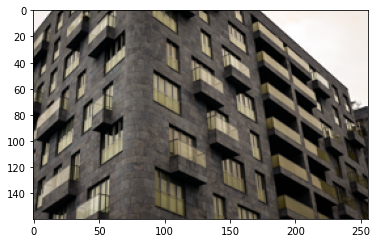

In [2]:
X = cv2.imread('/home/mandalinadagi/Desktop/comp511/img001x4.png')
Y = cv2.imread('/home/mandalinadagi/Desktop/comp511/img001.png')
wx, hx, c = X.shape
wx = (wx//4)*4
hx = (hx//4)*4
X = X[:wx, :hx, :]
Y = Y[:(4*wx), :(4*hx), :]
X_original = X
Y_original = Y
X = X.astype(float)
Y = Y.astype(float)
X /= 255.0
Y /= 255.0
print(X.dtype)
plt.imshow(X);
print(f"X: {X.shape}")
print(f"Y: {Y.shape}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr_son: (40, 64, 3)


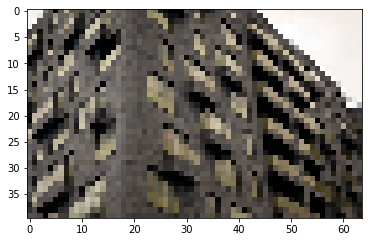

In [3]:
# Bi-CUBIC interpolation
lr_son = cv2.resize(X, None,fx=0.25, fy=0.25, interpolation=cv2.INTER_CUBIC)
plt.imshow(lr_son);
print(f"lr_son: {lr_son.shape}")

In [4]:
lr_son_tensor = torch.FloatTensor(lr_son)
lr_father_tensor = torch.FloatTensor(X)
HR_tensor = torch.FloatTensor(Y)
print(f"lr_son_tensor type: {lr_son_tensor.type()}, lr_father_tensor type: {lr_father_tensor.type()}, HR_tensor type: {HR_tensor.type()}")

lr_son_tensor type: torch.FloatTensor, lr_father_tensor type: torch.FloatTensor, HR_tensor type: torch.FloatTensor


In [5]:
print(f"lr_son: {lr_son_tensor.shape}, lr_father: {lr_father_tensor.shape}, HR: {HR_tensor.shape}")
lr_son, lr_father, HR = lr_son_tensor.unsqueeze(0), lr_father_tensor.unsqueeze(0), HR_tensor.unsqueeze(0)
print(f"lr_son: {lr_son.shape}, lr_father: {lr_father.shape}, HR: {HR.shape}")

lr_son: torch.Size([40, 64, 3]), lr_father: torch.Size([160, 256, 3]), HR: torch.Size([640, 1024, 3])
lr_son: torch.Size([1, 40, 64, 3]), lr_father: torch.Size([1, 160, 256, 3]), HR: torch.Size([1, 640, 1024, 3])


In [6]:
lr_son, lr_father, HR = lr_son.permute(0, 3, 1, 2), lr_father.permute(0, 3, 1, 2), HR.permute(0, 3, 1, 2)
print(f"lr_son: {lr_son.shape}, lr_father: {lr_father.shape}, HR: {HR.shape}")

lr_son: torch.Size([1, 3, 40, 64]), lr_father: torch.Size([1, 3, 160, 256]), HR: torch.Size([1, 3, 640, 1024])


# Training

In [7]:
EPOCHS = 20000
LR = 2e-5

In [8]:
# model = HourGlassNetMultiScaleInt(in_nc=3, 
#                                   out_nc=3, 
#                                   upscale=4,
#                                   nf=64,  
#                                   n_mid=1,
#                                  )
model = simpleNet()
model.to(device)
optim = optim.AdamW(model.parameters(), lr=LR)
inte_loss_weight = torch.Tensor([1.0, 2.0, 5.0, 1.0])
content_criterion = get_content_loss("L2", nn_func=False, use_cuda=True)

In [9]:
for epoch in range(EPOCHS):
    
    lr_FATHER = (0.257*lr_father[:, :1, :, :] + 0.564*lr_father[:, 1:2, :, :] + 0.098*lr_father[:, 2:, :, :] + 16/255.0) * 255.0
    map_corner = lr_FATHER.new(lr_FATHER.shape).fill_(0)
    map_edge = lr_FATHER.new(lr_FATHER.shape).fill_(0)
    map_flat = lr_FATHER.new(lr_FATHER.shape).fill_(0)
    lr_FATHER_numpy = np.transpose(lr_FATHER.numpy(), (0, 2, 3, 1))
    for i in range(lr_FATHER_numpy.shape[0]):
        dst = cv2.cornerHarris(lr_FATHER_numpy[i, :, :, 0], 3, 3, 0.04)
        thres1 = 0.01*dst.max()
        thres2 = -0.001*dst.max()
        map_corner[i, :, :, :] = torch.from_numpy(np.float32(dst > thres1))
        map_edge[i, :, :, :] = torch.from_numpy(np.float32(dst < thres2))
        map_flat[i, :, :, :] = torch.from_numpy(np.float32((dst > thres2) & (dst < thres1)))
    map_corner = map_corner.to(device)
    map_edge = map_edge.to(device)
    map_flat = map_flat.to(device)
    coe_list = []
    coe_list.append(map_flat)
    coe_list.append(map_edge)
    coe_list.append(map_corner)
    
#     sr_var, SR_map = model(lr_son.to(device))
    sr_var = model(lr_son.to(device))
    
    sr_loss = 0
    if isinstance(sr_var, list):
        #sr_loss = 0
        for i in range(len(sr_var)):
            if i != len(sr_var) - 1:
                coe = coe_list[i].to(device)
#                 print(coe.shape)
#                 print(sr_var[i].shape)
#                 print(lr_father.shape)
#                 print(lr_father.dtype)
                single_srloss = inte_loss_weight[i] * content_criterion(coe*sr_var[i], coe*(lr_father.to(device)))
            else:
                single_srloss = inte_loss_weight[i] * GW_loss(sr_var[i], (lr_father.to(device)))
            sr_loss += single_srloss
    else:
        sr_loss = content_criterion(sr_var, (lr_father.to(device)))
        
    optim.zero_grad()
    sr_loss.backward()
    optim.step()
    print(f"Epoch: {epoch}/{EPOCHS}, loss:{sr_loss}")

Epoch: 0/20000, loss:0.2167683094739914
Epoch: 1/20000, loss:0.20793397724628448
Epoch: 2/20000, loss:0.19944891333580017
Epoch: 3/20000, loss:0.1914537250995636
Epoch: 4/20000, loss:0.1839682012796402
Epoch: 5/20000, loss:0.17700208723545074
Epoch: 6/20000, loss:0.17056499421596527
Epoch: 7/20000, loss:0.16459548473358154
Epoch: 8/20000, loss:0.15903539955615997
Epoch: 9/20000, loss:0.15380075573921204
Epoch: 10/20000, loss:0.14881186187267303
Epoch: 11/20000, loss:0.14403194189071655
Epoch: 12/20000, loss:0.13943727314472198
Epoch: 13/20000, loss:0.13500753045082092
Epoch: 14/20000, loss:0.1307419389486313
Epoch: 15/20000, loss:0.12664832174777985
Epoch: 16/20000, loss:0.12274482101202011
Epoch: 17/20000, loss:0.11904189735651016
Epoch: 18/20000, loss:0.11551056802272797
Epoch: 19/20000, loss:0.11209090799093246
Epoch: 20/20000, loss:0.10877297818660736
Epoch: 21/20000, loss:0.1055486872792244
Epoch: 22/20000, loss:0.10242056101560593
Epoch: 23/20000, loss:0.09937639534473419
Epoch: 

Epoch: 194/20000, loss:0.020254405215382576
Epoch: 195/20000, loss:0.020168861374258995
Epoch: 196/20000, loss:0.020083868876099586
Epoch: 197/20000, loss:0.019999748095870018
Epoch: 198/20000, loss:0.019916512072086334
Epoch: 199/20000, loss:0.019834257662296295
Epoch: 200/20000, loss:0.0197527427226305
Epoch: 201/20000, loss:0.019672073423862457
Epoch: 202/20000, loss:0.019592054188251495
Epoch: 203/20000, loss:0.019512420520186424
Epoch: 204/20000, loss:0.01943308301270008
Epoch: 205/20000, loss:0.019354097545146942
Epoch: 206/20000, loss:0.01927540823817253
Epoch: 207/20000, loss:0.01919705420732498
Epoch: 208/20000, loss:0.01911948248744011
Epoch: 209/20000, loss:0.01904291659593582
Epoch: 210/20000, loss:0.018966903910040855
Epoch: 211/20000, loss:0.01889171078801155
Epoch: 212/20000, loss:0.01881735399365425
Epoch: 213/20000, loss:0.018743671476840973
Epoch: 214/20000, loss:0.018670424818992615
Epoch: 215/20000, loss:0.018597634509205818
Epoch: 216/20000, loss:0.0185254458338022

Epoch: 400/20000, loss:0.011768578551709652
Epoch: 401/20000, loss:0.011748824268579483
Epoch: 402/20000, loss:0.011729216203093529
Epoch: 403/20000, loss:0.011709773913025856
Epoch: 404/20000, loss:0.01169037725776434
Epoch: 405/20000, loss:0.011671067215502262
Epoch: 406/20000, loss:0.011651855893433094
Epoch: 407/20000, loss:0.011632782407104969
Epoch: 408/20000, loss:0.011613807640969753
Epoch: 409/20000, loss:0.01159489993005991
Epoch: 410/20000, loss:0.011576096527278423
Epoch: 411/20000, loss:0.011557387188076973
Epoch: 412/20000, loss:0.011538802646100521
Epoch: 413/20000, loss:0.011520323343575
Epoch: 414/20000, loss:0.011501947417855263
Epoch: 415/20000, loss:0.01148367952555418
Epoch: 416/20000, loss:0.011465512216091156
Epoch: 417/20000, loss:0.011447453871369362
Epoch: 418/20000, loss:0.0114295007660985
Epoch: 419/20000, loss:0.011411619372665882
Epoch: 420/20000, loss:0.01139382179826498
Epoch: 421/20000, loss:0.011376136913895607
Epoch: 422/20000, loss:0.0113585582002997

Epoch: 606/20000, loss:0.00905525404959917
Epoch: 607/20000, loss:0.009045825339853764
Epoch: 608/20000, loss:0.00903645996004343
Epoch: 609/20000, loss:0.00902715977281332
Epoch: 610/20000, loss:0.009017919190227985
Epoch: 611/20000, loss:0.009008715860545635
Epoch: 612/20000, loss:0.008999538607895374
Epoch: 613/20000, loss:0.008990369737148285
Epoch: 614/20000, loss:0.008981195278465748
Epoch: 615/20000, loss:0.008972055278718472
Epoch: 616/20000, loss:0.008962924592196941
Epoch: 617/20000, loss:0.0089538199827075
Epoch: 618/20000, loss:0.008944743312895298
Epoch: 619/20000, loss:0.00893567968159914
Epoch: 620/20000, loss:0.008926630020141602
Epoch: 621/20000, loss:0.008917579427361488
Epoch: 622/20000, loss:0.008908546529710293
Epoch: 623/20000, loss:0.008899517357349396
Epoch: 624/20000, loss:0.008890492841601372
Epoch: 625/20000, loss:0.008881453424692154
Epoch: 626/20000, loss:0.008872412145137787
Epoch: 627/20000, loss:0.008863372728228569
Epoch: 628/20000, loss:0.0088543379679

Epoch: 811/20000, loss:0.007491261698305607
Epoch: 812/20000, loss:0.007485221605747938
Epoch: 813/20000, loss:0.007478948216885328
Epoch: 814/20000, loss:0.007472519297152758
Epoch: 815/20000, loss:0.007465923670679331
Epoch: 816/20000, loss:0.0074593364261090755
Epoch: 817/20000, loss:0.007452872581779957
Epoch: 818/20000, loss:0.00744662806391716
Epoch: 819/20000, loss:0.0074405972845852375
Epoch: 820/20000, loss:0.007434725761413574
Epoch: 821/20000, loss:0.007428928278386593
Epoch: 822/20000, loss:0.007423103787004948
Epoch: 823/20000, loss:0.0074171870946884155
Epoch: 824/20000, loss:0.007411030121147633
Epoch: 825/20000, loss:0.007404771167784929
Epoch: 826/20000, loss:0.007398397196084261
Epoch: 827/20000, loss:0.00739205302670598
Epoch: 828/20000, loss:0.0073858387768268585
Epoch: 829/20000, loss:0.007379753980785608
Epoch: 830/20000, loss:0.007373807020485401
Epoch: 831/20000, loss:0.0073679727502167225
Epoch: 832/20000, loss:0.00736218923702836
Epoch: 833/20000, loss:0.00735

Epoch: 1016/20000, loss:0.006378063000738621
Epoch: 1017/20000, loss:0.006373199634253979
Epoch: 1018/20000, loss:0.006368555128574371
Epoch: 1019/20000, loss:0.006364041473716497
Epoch: 1020/20000, loss:0.006359598599374294
Epoch: 1021/20000, loss:0.006355199031531811
Epoch: 1022/20000, loss:0.006350711453706026
Epoch: 1023/20000, loss:0.006346199661493301
Epoch: 1024/20000, loss:0.006341428030282259
Epoch: 1025/20000, loss:0.00633647246286273
Epoch: 1026/20000, loss:0.006331336684525013
Epoch: 1027/20000, loss:0.006326138507574797
Epoch: 1028/20000, loss:0.006320933811366558
Epoch: 1029/20000, loss:0.006315870210528374
Epoch: 1030/20000, loss:0.006310978904366493
Epoch: 1031/20000, loss:0.006306264083832502
Epoch: 1032/20000, loss:0.0063017080537974834
Epoch: 1033/20000, loss:0.006297264713793993
Epoch: 1034/20000, loss:0.006292945705354214
Epoch: 1035/20000, loss:0.006288697477430105
Epoch: 1036/20000, loss:0.006284508388489485
Epoch: 1037/20000, loss:0.006280138157308102
Epoch: 103

Epoch: 1219/20000, loss:0.005475996993482113
Epoch: 1220/20000, loss:0.005471730604767799
Epoch: 1221/20000, loss:0.0054676407016813755
Epoch: 1222/20000, loss:0.005463689565658569
Epoch: 1223/20000, loss:0.005459875799715519
Epoch: 1224/20000, loss:0.005456268787384033
Epoch: 1225/20000, loss:0.005452870391309261
Epoch: 1226/20000, loss:0.005449673626571894
Epoch: 1227/20000, loss:0.005446534603834152
Epoch: 1228/20000, loss:0.005443297326564789
Epoch: 1229/20000, loss:0.005439613480120897
Epoch: 1230/20000, loss:0.005435344763100147
Epoch: 1231/20000, loss:0.005430318880826235
Epoch: 1232/20000, loss:0.005425033159554005
Epoch: 1233/20000, loss:0.005419858731329441
Epoch: 1234/20000, loss:0.0054152109660208225
Epoch: 1235/20000, loss:0.005411204416304827
Epoch: 1236/20000, loss:0.005407710559666157
Epoch: 1237/20000, loss:0.00540447561070323
Epoch: 1238/20000, loss:0.005401193164288998
Epoch: 1239/20000, loss:0.0053976476192474365
Epoch: 1240/20000, loss:0.005393573548644781
Epoch: 1

Epoch: 1421/20000, loss:0.004721461329609156
Epoch: 1422/20000, loss:0.00471802381798625
Epoch: 1423/20000, loss:0.004714107606559992
Epoch: 1424/20000, loss:0.004709840286523104
Epoch: 1425/20000, loss:0.004705436993390322
Epoch: 1426/20000, loss:0.004701232071965933
Epoch: 1427/20000, loss:0.004697341006249189
Epoch: 1428/20000, loss:0.00469384016469121
Epoch: 1429/20000, loss:0.004690659698098898
Epoch: 1430/20000, loss:0.004687740467488766
Epoch: 1431/20000, loss:0.004685085266828537
Epoch: 1432/20000, loss:0.004682622384279966
Epoch: 1433/20000, loss:0.004680225159972906
Epoch: 1434/20000, loss:0.004677641671150923
Epoch: 1435/20000, loss:0.004674512427300215
Epoch: 1436/20000, loss:0.0046706609427928925
Epoch: 1437/20000, loss:0.004666414111852646
Epoch: 1438/20000, loss:0.004661926534026861
Epoch: 1439/20000, loss:0.004657596815377474
Epoch: 1440/20000, loss:0.004653687123209238
Epoch: 1441/20000, loss:0.004650217946618795
Epoch: 1442/20000, loss:0.004647069610655308
Epoch: 1443

Epoch: 1628/20000, loss:0.004077657125890255
Epoch: 1629/20000, loss:0.004074034281075001
Epoch: 1630/20000, loss:0.004070301540195942
Epoch: 1631/20000, loss:0.0040665483102202415
Epoch: 1632/20000, loss:0.004063016269356012
Epoch: 1633/20000, loss:0.004059783648699522
Epoch: 1634/20000, loss:0.004056820645928383
Epoch: 1635/20000, loss:0.004054092802107334
Epoch: 1636/20000, loss:0.004051512572914362
Epoch: 1637/20000, loss:0.004049117676913738
Epoch: 1638/20000, loss:0.0040468499064445496
Epoch: 1639/20000, loss:0.004044770263135433
Epoch: 1640/20000, loss:0.004042736254632473
Epoch: 1641/20000, loss:0.00404072180390358
Epoch: 1642/20000, loss:0.004038454964756966
Epoch: 1643/20000, loss:0.004035799764096737
Epoch: 1644/20000, loss:0.004032646771520376
Epoch: 1645/20000, loss:0.004029117524623871
Epoch: 1646/20000, loss:0.0040252055041491985
Epoch: 1647/20000, loss:0.00402125483378768
Epoch: 1648/20000, loss:0.004017428960651159
Epoch: 1649/20000, loss:0.004013995174318552
Epoch: 16

Epoch: 1809/20000, loss:0.0035929118748754263
Epoch: 1810/20000, loss:0.0035910855513066053
Epoch: 1811/20000, loss:0.003589069005101919
Epoch: 1812/20000, loss:0.003586767241358757
Epoch: 1813/20000, loss:0.00358418095856905
Epoch: 1814/20000, loss:0.003581323893740773
Epoch: 1815/20000, loss:0.003578273579478264
Epoch: 1816/20000, loss:0.003575096605345607
Epoch: 1817/20000, loss:0.003571941051632166
Epoch: 1818/20000, loss:0.003568933578208089
Epoch: 1819/20000, loss:0.0035662001464515924
Epoch: 1820/20000, loss:0.003563742619007826
Epoch: 1821/20000, loss:0.0035615155939012766
Epoch: 1822/20000, loss:0.003559462958946824
Epoch: 1823/20000, loss:0.0035575306974351406
Epoch: 1824/20000, loss:0.0035557267256081104
Epoch: 1825/20000, loss:0.003554126713424921
Epoch: 1826/20000, loss:0.003552698763087392
Epoch: 1827/20000, loss:0.003551386995241046
Epoch: 1828/20000, loss:0.003549874061718583
Epoch: 1829/20000, loss:0.003548049135133624
Epoch: 1830/20000, loss:0.003545573214069009
Epoch

Epoch: 2012/20000, loss:0.003115711733698845
Epoch: 2013/20000, loss:0.0031135515309870243
Epoch: 2014/20000, loss:0.0031117391772568226
Epoch: 2015/20000, loss:0.0031101584900170565
Epoch: 2016/20000, loss:0.003108773846179247
Epoch: 2017/20000, loss:0.0031075410079210997
Epoch: 2018/20000, loss:0.0031064050272107124
Epoch: 2019/20000, loss:0.0031053212005645037
Epoch: 2020/20000, loss:0.003104170085862279
Epoch: 2021/20000, loss:0.0031028585508465767
Epoch: 2022/20000, loss:0.003101108130067587
Epoch: 2023/20000, loss:0.003099042223766446
Epoch: 2024/20000, loss:0.0030965006444603205
Epoch: 2025/20000, loss:0.003093720180913806
Epoch: 2026/20000, loss:0.003090732963755727
Epoch: 2027/20000, loss:0.0030878381803631783
Epoch: 2028/20000, loss:0.003085194155573845
Epoch: 2029/20000, loss:0.0030828884337097406
Epoch: 2030/20000, loss:0.0030809035524725914
Epoch: 2031/20000, loss:0.003079167567193508
Epoch: 2032/20000, loss:0.0030776248313486576
Epoch: 2033/20000, loss:0.00307627231813967

Epoch: 2215/20000, loss:0.0027733100578188896
Epoch: 2216/20000, loss:0.0027727456763386726
Epoch: 2217/20000, loss:0.002772355219349265
Epoch: 2218/20000, loss:0.0027718108613044024
Epoch: 2219/20000, loss:0.0027712020091712475
Epoch: 2220/20000, loss:0.002770001767203212
Epoch: 2221/20000, loss:0.0027683451771736145
Epoch: 2222/20000, loss:0.0027659572660923004
Epoch: 2223/20000, loss:0.0027633081190288067
Epoch: 2224/20000, loss:0.002760553965345025
Epoch: 2225/20000, loss:0.002758034970611334
Epoch: 2226/20000, loss:0.002755815628916025
Epoch: 2227/20000, loss:0.002753977198153734
Epoch: 2228/20000, loss:0.002752474043518305
Epoch: 2229/20000, loss:0.002751222811639309
Epoch: 2230/20000, loss:0.0027501776348799467
Epoch: 2231/20000, loss:0.0027493354864418507
Epoch: 2232/20000, loss:0.0027486861217767
Epoch: 2233/20000, loss:0.002748137107118964
Epoch: 2234/20000, loss:0.0027476802933961153
Epoch: 2235/20000, loss:0.0027470197528600693
Epoch: 2236/20000, loss:0.0027461759746074677


Epoch: 2415/20000, loss:0.0025048733223229647
Epoch: 2416/20000, loss:0.002503438387066126
Epoch: 2417/20000, loss:0.0025016055442392826
Epoch: 2418/20000, loss:0.0024993461556732655
Epoch: 2419/20000, loss:0.002496923552826047
Epoch: 2420/20000, loss:0.0024945158511400223
Epoch: 2421/20000, loss:0.0024924154859036207
Epoch: 2422/20000, loss:0.00249074911698699
Epoch: 2423/20000, loss:0.002489520702511072
Epoch: 2424/20000, loss:0.002488604513928294
Epoch: 2425/20000, loss:0.0024879297707229853
Epoch: 2426/20000, loss:0.0024874575901776552
Epoch: 2427/20000, loss:0.0024871020577847958
Epoch: 2428/20000, loss:0.0024867986794561148
Epoch: 2429/20000, loss:0.002486328361555934
Epoch: 2430/20000, loss:0.002485702047124505
Epoch: 2431/20000, loss:0.002484668977558613
Epoch: 2432/20000, loss:0.0024832964409142733
Epoch: 2433/20000, loss:0.002481481758877635
Epoch: 2434/20000, loss:0.0024794009514153004
Epoch: 2435/20000, loss:0.0024770782329142094
Epoch: 2436/20000, loss:0.002474827691912651

Epoch: 2618/20000, loss:0.0022722233552485704
Epoch: 2619/20000, loss:0.00227000517770648
Epoch: 2620/20000, loss:0.0022679707035422325
Epoch: 2621/20000, loss:0.0022662885021418333
Epoch: 2622/20000, loss:0.002265040297061205
Epoch: 2623/20000, loss:0.0022641958203166723
Epoch: 2624/20000, loss:0.0022636440116912127
Epoch: 2625/20000, loss:0.002263261005282402
Epoch: 2626/20000, loss:0.002262977883219719
Epoch: 2627/20000, loss:0.0022627434227615595
Epoch: 2628/20000, loss:0.0022624763660132885
Epoch: 2629/20000, loss:0.0022619948722422123
Epoch: 2630/20000, loss:0.002261440036818385
Epoch: 2631/20000, loss:0.0022605392150580883
Epoch: 2632/20000, loss:0.002259477274492383
Epoch: 2633/20000, loss:0.002257951768115163
Epoch: 2634/20000, loss:0.0022562381345778704
Epoch: 2635/20000, loss:0.0022542732767760754
Epoch: 2636/20000, loss:0.0022523109801113605
Epoch: 2637/20000, loss:0.0022504657972604036
Epoch: 2638/20000, loss:0.00224889675155282
Epoch: 2639/20000, loss:0.002247670898213982

Epoch: 2818/20000, loss:0.0020791238639503717
Epoch: 2819/20000, loss:0.0020769627299159765
Epoch: 2820/20000, loss:0.002074840944260359
Epoch: 2821/20000, loss:0.002073094714432955
Epoch: 2822/20000, loss:0.0020717624574899673
Epoch: 2823/20000, loss:0.002070832531899214
Epoch: 2824/20000, loss:0.002070176415145397
Epoch: 2825/20000, loss:0.0020697377622127533
Epoch: 2826/20000, loss:0.0020695326384156942
Epoch: 2827/20000, loss:0.002069501904770732
Epoch: 2828/20000, loss:0.002069680020213127
Epoch: 2829/20000, loss:0.002069680718705058
Epoch: 2830/20000, loss:0.0020696730352938175
Epoch: 2831/20000, loss:0.002069226698949933
Epoch: 2832/20000, loss:0.0020686036441475153
Epoch: 2833/20000, loss:0.0020672769751399755
Epoch: 2834/20000, loss:0.002065719570964575
Epoch: 2835/20000, loss:0.0020636371336877346
Epoch: 2836/20000, loss:0.002061516046524048
Epoch: 2837/20000, loss:0.0020594613160938025
Epoch: 2838/20000, loss:0.0020577842369675636
Epoch: 2839/20000, loss:0.002056521829217672

Epoch: 3019/20000, loss:0.001906935591250658
Epoch: 3020/20000, loss:0.001906162011437118
Epoch: 3021/20000, loss:0.0019055980956181884
Epoch: 3022/20000, loss:0.0019052327843382955
Epoch: 3023/20000, loss:0.0019050707342103124
Epoch: 3024/20000, loss:0.0019051162526011467
Epoch: 3025/20000, loss:0.0019052844727411866
Epoch: 3026/20000, loss:0.0019056695746257901
Epoch: 3027/20000, loss:0.0019058515317738056
Epoch: 3028/20000, loss:0.001906034187413752
Epoch: 3029/20000, loss:0.0019056518794968724
Epoch: 3030/20000, loss:0.0019050592090934515
Epoch: 3031/20000, loss:0.001903580967336893
Epoch: 3032/20000, loss:0.0019018264720216393
Epoch: 3033/20000, loss:0.0018995924619957805
Epoch: 3034/20000, loss:0.0018973811529576778
Epoch: 3035/20000, loss:0.001895420253276825
Epoch: 3036/20000, loss:0.0018939789151772857
Epoch: 3037/20000, loss:0.0018930378137156367
Epoch: 3038/20000, loss:0.0018924291944131255
Epoch: 3039/20000, loss:0.0018920751754194498
Epoch: 3040/20000, loss:0.0018919941503

Epoch: 3219/20000, loss:0.0017620896687731147
Epoch: 3220/20000, loss:0.0017619673162698746
Epoch: 3221/20000, loss:0.0017620294820517302
Epoch: 3222/20000, loss:0.001762298052199185
Epoch: 3223/20000, loss:0.0017625839682295918
Epoch: 3224/20000, loss:0.0017629570793360472
Epoch: 3225/20000, loss:0.001763026462867856
Epoch: 3226/20000, loss:0.001763066160492599
Epoch: 3227/20000, loss:0.0017624892061576247
Epoch: 3228/20000, loss:0.0017617151606827974
Epoch: 3229/20000, loss:0.0017601195722818375
Epoch: 3230/20000, loss:0.0017583075677976012
Epoch: 3231/20000, loss:0.0017562222201377153
Epoch: 3232/20000, loss:0.0017543068388476968
Epoch: 3233/20000, loss:0.0017527726013213396
Epoch: 3234/20000, loss:0.0017517398810014129
Epoch: 3235/20000, loss:0.0017511786427348852
Epoch: 3236/20000, loss:0.0017509643221274018
Epoch: 3237/20000, loss:0.0017509893514215946
Epoch: 3238/20000, loss:0.0017511219484731555
Epoch: 3239/20000, loss:0.0017513849306851625
Epoch: 3240/20000, loss:0.00175148888

Epoch: 3423/20000, loss:0.0016315467655658722
Epoch: 3424/20000, loss:0.0016314724925905466
Epoch: 3425/20000, loss:0.0016315700486302376
Epoch: 3426/20000, loss:0.0016319082351401448
Epoch: 3427/20000, loss:0.0016322600422427058
Epoch: 3428/20000, loss:0.0016326329205185175
Epoch: 3429/20000, loss:0.0016326303593814373
Epoch: 3430/20000, loss:0.0016326280310750008
Epoch: 3431/20000, loss:0.0016320557333528996
Epoch: 3432/20000, loss:0.001631133840419352
Epoch: 3433/20000, loss:0.0016296119429171085
Epoch: 3434/20000, loss:0.001627931371331215
Epoch: 3435/20000, loss:0.001626041834242642
Epoch: 3436/20000, loss:0.0016243349527940154
Epoch: 3437/20000, loss:0.0016230070032179356
Epoch: 3438/20000, loss:0.0016221337718889117
Epoch: 3439/20000, loss:0.0016216343501582742
Epoch: 3440/20000, loss:0.0016213973285630345
Epoch: 3441/20000, loss:0.0016213895287364721
Epoch: 3442/20000, loss:0.0016215896466746926
Epoch: 3443/20000, loss:0.0016219925601035357
Epoch: 3444/20000, loss:0.00162247405

Epoch: 3602/20000, loss:0.0015312369214370847
Epoch: 3603/20000, loss:0.0015296477358788252
Epoch: 3604/20000, loss:0.0015281300293281674
Epoch: 3605/20000, loss:0.0015269158175215125
Epoch: 3606/20000, loss:0.001526105566881597
Epoch: 3607/20000, loss:0.0015256364131346345
Epoch: 3608/20000, loss:0.001525398693047464
Epoch: 3609/20000, loss:0.0015253148740157485
Epoch: 3610/20000, loss:0.0015254109166562557
Epoch: 3611/20000, loss:0.001525680534541607
Epoch: 3612/20000, loss:0.0015260993968695402
Epoch: 3613/20000, loss:0.0015266595873981714
Epoch: 3614/20000, loss:0.0015270323492586613
Epoch: 3615/20000, loss:0.001527514192275703
Epoch: 3616/20000, loss:0.0015275535406544805
Epoch: 3617/20000, loss:0.001527366111986339
Epoch: 3618/20000, loss:0.0015262514352798462
Epoch: 3619/20000, loss:0.0015247729606926441
Epoch: 3620/20000, loss:0.0015227748081088066
Epoch: 3621/20000, loss:0.001520639518275857
Epoch: 3622/20000, loss:0.0015186842065304518
Epoch: 3623/20000, loss:0.00151722121518

Epoch: 3804/20000, loss:0.0014290710678324103
Epoch: 3805/20000, loss:0.001429120427928865
Epoch: 3806/20000, loss:0.0014290140243247151
Epoch: 3807/20000, loss:0.0014283047057688236
Epoch: 3808/20000, loss:0.0014272626722231507
Epoch: 3809/20000, loss:0.0014256200520321727
Epoch: 3810/20000, loss:0.0014238181756809354
Epoch: 3811/20000, loss:0.0014221093151718378
Epoch: 3812/20000, loss:0.0014207505155354738
Epoch: 3813/20000, loss:0.0014197787968441844
Epoch: 3814/20000, loss:0.0014191153459250927
Epoch: 3815/20000, loss:0.0014186982298269868
Epoch: 3816/20000, loss:0.0014185057953000069
Epoch: 3817/20000, loss:0.0014185082400217652
Epoch: 3818/20000, loss:0.0014186735497787595
Epoch: 3819/20000, loss:0.0014189020730555058
Epoch: 3820/20000, loss:0.0014192418893799186
Epoch: 3821/20000, loss:0.0014196773990988731
Epoch: 3822/20000, loss:0.001420055516064167
Epoch: 3823/20000, loss:0.0014203652972355485
Epoch: 3824/20000, loss:0.001420099986717105
Epoch: 3825/20000, loss:0.00141968438

Epoch: 4003/20000, loss:0.0013351518427953124
Epoch: 4004/20000, loss:0.0013353537069633603
Epoch: 4005/20000, loss:0.0013357583666220307
Epoch: 4006/20000, loss:0.0013356786221265793
Epoch: 4007/20000, loss:0.0013354237889871001
Epoch: 4008/20000, loss:0.0013346272753551602
Epoch: 4009/20000, loss:0.0013337908312678337
Epoch: 4010/20000, loss:0.0013324288884177804
Epoch: 4011/20000, loss:0.0013308366760611534
Epoch: 4012/20000, loss:0.0013291373616084456
Epoch: 4013/20000, loss:0.0013277461985126138
Epoch: 4014/20000, loss:0.0013266932219266891
Epoch: 4015/20000, loss:0.0013259046245366335
Epoch: 4016/20000, loss:0.001325361430644989
Epoch: 4017/20000, loss:0.0013251436175778508
Epoch: 4018/20000, loss:0.001325195305980742
Epoch: 4019/20000, loss:0.001325408462435007
Epoch: 4020/20000, loss:0.001325690420344472
Epoch: 4021/20000, loss:0.0013260242994874716
Epoch: 4022/20000, loss:0.0013265531742945313
Epoch: 4023/20000, loss:0.0013270353665575385
Epoch: 4024/20000, loss:0.001327655394

Epoch: 4204/20000, loss:0.0012486801715567708
Epoch: 4205/20000, loss:0.0012494082329794765
Epoch: 4206/20000, loss:0.0012502375757321715
Epoch: 4207/20000, loss:0.0012505606282502413
Epoch: 4208/20000, loss:0.0012506120838224888
Epoch: 4209/20000, loss:0.0012497397838160396
Epoch: 4210/20000, loss:0.0012485436163842678
Epoch: 4211/20000, loss:0.0012467988999560475
Epoch: 4212/20000, loss:0.0012450313661247492
Epoch: 4213/20000, loss:0.001243299338966608
Epoch: 4214/20000, loss:0.001241967547684908
Epoch: 4215/20000, loss:0.0012411992065608501
Epoch: 4216/20000, loss:0.001240937621332705
Epoch: 4217/20000, loss:0.0012409696355462074
Epoch: 4218/20000, loss:0.0012411316856741905
Epoch: 4219/20000, loss:0.0012414223747327924
Epoch: 4220/20000, loss:0.0012417803518474102
Epoch: 4221/20000, loss:0.0012422113213688135
Epoch: 4222/20000, loss:0.0012423829175531864
Epoch: 4223/20000, loss:0.001242459169588983
Epoch: 4224/20000, loss:0.0012421191204339266
Epoch: 4225/20000, loss:0.001241753809

Epoch: 4404/20000, loss:0.001168295624665916
Epoch: 4405/20000, loss:0.001167754177004099
Epoch: 4406/20000, loss:0.0011676213471218944
Epoch: 4407/20000, loss:0.0011678311275318265
Epoch: 4408/20000, loss:0.0011683051707223058
Epoch: 4409/20000, loss:0.0011690100654959679
Epoch: 4410/20000, loss:0.0011696002911776304
Epoch: 4411/20000, loss:0.0011702630436047912
Epoch: 4412/20000, loss:0.0011705163633450866
Epoch: 4413/20000, loss:0.0011708516394719481
Epoch: 4414/20000, loss:0.0011704365024343133
Epoch: 4415/20000, loss:0.001169836730696261
Epoch: 4416/20000, loss:0.0011684534838423133
Epoch: 4417/20000, loss:0.0011669548694044352
Epoch: 4418/20000, loss:0.001165197929367423
Epoch: 4419/20000, loss:0.0011636550771072507
Epoch: 4420/20000, loss:0.0011624443577602506
Epoch: 4421/20000, loss:0.0011617423733696342
Epoch: 4422/20000, loss:0.0011615235125645995
Epoch: 4423/20000, loss:0.0011616603005677462
Epoch: 4424/20000, loss:0.0011620286386460066
Epoch: 4425/20000, loss:0.001162463449

Epoch: 4604/20000, loss:0.00110645464155823
Epoch: 4605/20000, loss:0.001106837997213006
Epoch: 4606/20000, loss:0.0011058144737035036
Epoch: 4607/20000, loss:0.0011041916441172361
Epoch: 4608/20000, loss:0.0011015549534931779
Epoch: 4609/20000, loss:0.0010990973096340895
Epoch: 4610/20000, loss:0.0010968658607453108
Epoch: 4611/20000, loss:0.0010953097371384501
Epoch: 4612/20000, loss:0.0010944806272163987
Epoch: 4613/20000, loss:0.001094376901164651
Epoch: 4614/20000, loss:0.0010948246344923973
Epoch: 4615/20000, loss:0.001095595653168857
Epoch: 4616/20000, loss:0.0010965715628117323
Epoch: 4617/20000, loss:0.0010973314056172967
Epoch: 4618/20000, loss:0.001098046312108636
Epoch: 4619/20000, loss:0.001098207663744688
Epoch: 4620/20000, loss:0.0010981736704707146
Epoch: 4621/20000, loss:0.0010971807641908526
Epoch: 4622/20000, loss:0.0010958726052194834
Epoch: 4623/20000, loss:0.0010940274223685265
Epoch: 4624/20000, loss:0.0010923015652224422
Epoch: 4625/20000, loss:0.001090839388780

Epoch: 4805/20000, loss:0.0010371168609708548
Epoch: 4806/20000, loss:0.001037516980431974
Epoch: 4807/20000, loss:0.0010371628450229764
Epoch: 4808/20000, loss:0.0010367867071181536
Epoch: 4809/20000, loss:0.001035910565406084
Epoch: 4810/20000, loss:0.0010351184755563736
Epoch: 4811/20000, loss:0.0010338565334677696
Epoch: 4812/20000, loss:0.0010324676986783743
Epoch: 4813/20000, loss:0.0010309666395187378
Epoch: 4814/20000, loss:0.0010297872358933091
Epoch: 4815/20000, loss:0.0010290087666362524
Epoch: 4816/20000, loss:0.001028593978844583
Epoch: 4817/20000, loss:0.0010283425217494369
Epoch: 4818/20000, loss:0.0010281855938956141
Epoch: 4819/20000, loss:0.001028069294989109
Epoch: 4820/20000, loss:0.0010280879214406013
Epoch: 4821/20000, loss:0.0010283122537657619
Epoch: 4822/20000, loss:0.0010286275064572692
Epoch: 4823/20000, loss:0.0010290880454704165
Epoch: 4824/20000, loss:0.001029317150823772
Epoch: 4825/20000, loss:0.0010297172702848911
Epoch: 4826/20000, loss:0.0010299505665

Epoch: 5008/20000, loss:0.0009718364453874528
Epoch: 5009/20000, loss:0.0009712298051454127
Epoch: 5010/20000, loss:0.000970975961536169
Epoch: 5011/20000, loss:0.0009709162404760718
Epoch: 5012/20000, loss:0.0009710312588140368
Epoch: 5013/20000, loss:0.000971295521594584
Epoch: 5014/20000, loss:0.0009716282947920263
Epoch: 5015/20000, loss:0.0009721065871417522
Epoch: 5016/20000, loss:0.0009723709081299603
Epoch: 5017/20000, loss:0.0009726488497108221
Epoch: 5018/20000, loss:0.0009726229473017156
Epoch: 5019/20000, loss:0.000972772715613246
Epoch: 5020/20000, loss:0.0009726234711706638
Epoch: 5021/20000, loss:0.0009724795236252248
Epoch: 5022/20000, loss:0.0009717285865917802
Epoch: 5023/20000, loss:0.0009708350407890975
Epoch: 5024/20000, loss:0.0009696854394860566
Epoch: 5025/20000, loss:0.0009686984703876078
Epoch: 5026/20000, loss:0.0009677273337729275
Epoch: 5027/20000, loss:0.0009669095743447542
Epoch: 5028/20000, loss:0.0009660946670919657
Epoch: 5029/20000, loss:0.00096544157

Epoch: 5208/20000, loss:0.0009216090547852218
Epoch: 5209/20000, loss:0.0009213513694703579
Epoch: 5210/20000, loss:0.0009202801738865674
Epoch: 5211/20000, loss:0.0009189923875965178
Epoch: 5212/20000, loss:0.0009175305021926761
Epoch: 5213/20000, loss:0.0009163121576420963
Epoch: 5214/20000, loss:0.0009154818253591657
Epoch: 5215/20000, loss:0.0009150757687166333
Epoch: 5216/20000, loss:0.0009150244295597076
Epoch: 5217/20000, loss:0.0009151955018751323
Epoch: 5218/20000, loss:0.0009155123843811452
Epoch: 5219/20000, loss:0.0009158099419437349
Epoch: 5220/20000, loss:0.0009161101770587265
Epoch: 5221/20000, loss:0.0009162324131466448
Epoch: 5222/20000, loss:0.0009163399809040129
Epoch: 5223/20000, loss:0.0009161267662420869
Epoch: 5224/20000, loss:0.0009158504544757307
Epoch: 5225/20000, loss:0.000915306736715138
Epoch: 5226/20000, loss:0.0009148167446255684
Epoch: 5227/20000, loss:0.0009141286136582494
Epoch: 5228/20000, loss:0.0009134787833318114
Epoch: 5229/20000, loss:0.000912655

Epoch: 5408/20000, loss:0.0008673597476445138
Epoch: 5409/20000, loss:0.0008670265669934452
Epoch: 5410/20000, loss:0.0008667471702210605
Epoch: 5411/20000, loss:0.0008665883797220886
Epoch: 5412/20000, loss:0.0008665987988933921
Epoch: 5413/20000, loss:0.0008667840738780797
Epoch: 5414/20000, loss:0.0008671201067045331
Epoch: 5415/20000, loss:0.0008675623103044927
Epoch: 5416/20000, loss:0.000868132570758462
Epoch: 5417/20000, loss:0.0008689290843904018
Epoch: 5418/20000, loss:0.000870515825226903
Epoch: 5419/20000, loss:0.0008723289938643575
Epoch: 5420/20000, loss:0.0008745364029891789
Epoch: 5421/20000, loss:0.0008756844326853752
Epoch: 5422/20000, loss:0.0008765404927544296
Epoch: 5423/20000, loss:0.0008757889154367149
Epoch: 5424/20000, loss:0.0008745062514208257
Epoch: 5425/20000, loss:0.0008715699077583849
Epoch: 5426/20000, loss:0.0008683212217874825
Epoch: 5427/20000, loss:0.0008651197422295809
Epoch: 5428/20000, loss:0.0008630649535916746
Epoch: 5429/20000, loss:0.0008622574

Epoch: 5609/20000, loss:0.0008243552292697132
Epoch: 5610/20000, loss:0.0008237613365054131
Epoch: 5611/20000, loss:0.0008228556835092604
Epoch: 5612/20000, loss:0.0008219282608479261
Epoch: 5613/20000, loss:0.0008209376828745008
Epoch: 5614/20000, loss:0.0008201004820875823
Epoch: 5615/20000, loss:0.0008194347028620541
Epoch: 5616/20000, loss:0.0008190515218302608
Epoch: 5617/20000, loss:0.0008189125801436603
Epoch: 5618/20000, loss:0.0008189303334802389
Epoch: 5619/20000, loss:0.0008190726512111723
Epoch: 5620/20000, loss:0.0008192614186555147
Epoch: 5621/20000, loss:0.0008195168920792639
Epoch: 5622/20000, loss:0.000819704495370388
Epoch: 5623/20000, loss:0.0008199636940844357
Epoch: 5624/20000, loss:0.000820128945633769
Epoch: 5625/20000, loss:0.0008205482154153287
Epoch: 5626/20000, loss:0.0008209163206629455
Epoch: 5627/20000, loss:0.0008215024718083441
Epoch: 5628/20000, loss:0.0008217716822400689
Epoch: 5629/20000, loss:0.0008220179588533938
Epoch: 5630/20000, loss:0.0008216941

Epoch: 5810/20000, loss:0.0007798799779266119
Epoch: 5811/20000, loss:0.0007805661880411208
Epoch: 5812/20000, loss:0.0007814201526343822
Epoch: 5813/20000, loss:0.0007818096783012152
Epoch: 5814/20000, loss:0.0007820460014045238
Epoch: 5815/20000, loss:0.0007816286524757743
Epoch: 5816/20000, loss:0.0007812417461536825
Epoch: 5817/20000, loss:0.0007805579225532711
Epoch: 5818/20000, loss:0.0007798571605235338
Epoch: 5819/20000, loss:0.0007788173970766366
Epoch: 5820/20000, loss:0.0007776935817673802
Epoch: 5821/20000, loss:0.0007765945629216731
Epoch: 5822/20000, loss:0.0007757955463603139
Epoch: 5823/20000, loss:0.000775379769038409
Epoch: 5824/20000, loss:0.0007752901292406023
Epoch: 5825/20000, loss:0.0007753185927867889
Epoch: 5826/20000, loss:0.0007753933314234018
Epoch: 5827/20000, loss:0.000775473250541836
Epoch: 5828/20000, loss:0.0007755782571621239
Epoch: 5829/20000, loss:0.0007758683641441166
Epoch: 5830/20000, loss:0.0007762543973512948
Epoch: 5831/20000, loss:0.0007768524

Epoch: 6010/20000, loss:0.0007401865441352129
Epoch: 6011/20000, loss:0.0007392583647742867
Epoch: 6012/20000, loss:0.0007385776261799037
Epoch: 6013/20000, loss:0.0007381835021078587
Epoch: 6014/20000, loss:0.0007380622555501759
Epoch: 6015/20000, loss:0.0007380362367257476
Epoch: 6016/20000, loss:0.0007380389142781496
Epoch: 6017/20000, loss:0.0007379932212643325
Epoch: 6018/20000, loss:0.0007380062597803771
Epoch: 6019/20000, loss:0.0007381621398963034
Epoch: 6020/20000, loss:0.0007384599884971976
Epoch: 6021/20000, loss:0.0007390992832370102
Epoch: 6022/20000, loss:0.000739842769689858
Epoch: 6023/20000, loss:0.0007409349200315773
Epoch: 6024/20000, loss:0.0007418350432999432
Epoch: 6025/20000, loss:0.0007431494304910302
Epoch: 6026/20000, loss:0.0007441641646437347
Epoch: 6027/20000, loss:0.0007455412414856255
Epoch: 6028/20000, loss:0.0007459770422428846
Epoch: 6029/20000, loss:0.0007459582411684096
Epoch: 6030/20000, loss:0.0007443316862918437
Epoch: 6031/20000, loss:0.000742364

Epoch: 6210/20000, loss:0.0007048541447147727
Epoch: 6211/20000, loss:0.0007053076406009495
Epoch: 6212/20000, loss:0.0007056447793729603
Epoch: 6213/20000, loss:0.0007062101503834128
Epoch: 6214/20000, loss:0.00070641451748088
Epoch: 6215/20000, loss:0.0007066346588544548
Epoch: 6216/20000, loss:0.0007062286604195833
Epoch: 6217/20000, loss:0.0007059285417199135
Epoch: 6218/20000, loss:0.000705254846252501
Epoch: 6219/20000, loss:0.0007048193947412074
Epoch: 6220/20000, loss:0.0007040670025162399
Epoch: 6221/20000, loss:0.0007032419671304524
Epoch: 6222/20000, loss:0.000702137011103332
Epoch: 6223/20000, loss:0.0007009995169937611
Epoch: 6224/20000, loss:0.0007000798359513283
Epoch: 6225/20000, loss:0.0006995659205131233
Epoch: 6226/20000, loss:0.0006994144059717655
Epoch: 6227/20000, loss:0.0006994766881689429
Epoch: 6228/20000, loss:0.0006994623690843582
Epoch: 6229/20000, loss:0.00069940130924806
Epoch: 6230/20000, loss:0.0006992665585130453
Epoch: 6231/20000, loss:0.00069922051625

Epoch: 6410/20000, loss:0.0006693645264022052
Epoch: 6411/20000, loss:0.0006688580615445971
Epoch: 6412/20000, loss:0.0006686145788989961
Epoch: 6413/20000, loss:0.0006684208055958152
Epoch: 6414/20000, loss:0.0006682270905002952
Epoch: 6415/20000, loss:0.0006678110803477466
Epoch: 6416/20000, loss:0.0006673741154372692
Epoch: 6417/20000, loss:0.0006669973954558372
Epoch: 6418/20000, loss:0.0006668057758361101
Epoch: 6419/20000, loss:0.0006667263805866241
Epoch: 6420/20000, loss:0.0006666913395747542
Epoch: 6421/20000, loss:0.0006666792905889452
Epoch: 6422/20000, loss:0.0006665675900876522
Epoch: 6423/20000, loss:0.000666461477521807
Epoch: 6424/20000, loss:0.0006663281237706542
Epoch: 6425/20000, loss:0.0006663054809905589
Epoch: 6426/20000, loss:0.0006664750981144607
Epoch: 6427/20000, loss:0.0006670360453426838
Epoch: 6428/20000, loss:0.0006679972284473479
Epoch: 6429/20000, loss:0.0006697800126858056
Epoch: 6430/20000, loss:0.000672166992444545
Epoch: 6431/20000, loss:0.0006756516

Epoch: 6608/20000, loss:0.0006412575021386147
Epoch: 6609/20000, loss:0.0006417051190510392
Epoch: 6610/20000, loss:0.0006416423129849136
Epoch: 6611/20000, loss:0.0006412087823264301
Epoch: 6612/20000, loss:0.0006400409620255232
Epoch: 6613/20000, loss:0.0006385839660651982
Epoch: 6614/20000, loss:0.0006372000207193196
Epoch: 6615/20000, loss:0.0006363063002936542
Epoch: 6616/20000, loss:0.0006359030958265066
Epoch: 6617/20000, loss:0.00063585105817765
Epoch: 6618/20000, loss:0.0006359291728585958
Epoch: 6619/20000, loss:0.0006360913394019008
Epoch: 6620/20000, loss:0.0006363485590554774
Epoch: 6621/20000, loss:0.000636675744317472
Epoch: 6622/20000, loss:0.0006371237686835229
Epoch: 6623/20000, loss:0.0006374805234372616
Epoch: 6624/20000, loss:0.0006378506077453494
Epoch: 6625/20000, loss:0.0006379036931321025
Epoch: 6626/20000, loss:0.0006378789548762143
Epoch: 6627/20000, loss:0.0006375238299369812
Epoch: 6628/20000, loss:0.0006372171337716281
Epoch: 6629/20000, loss:0.00063670863

Epoch: 6808/20000, loss:0.0006111602997407317
Epoch: 6809/20000, loss:0.0006108990055508912
Epoch: 6810/20000, loss:0.0006101959734223783
Epoch: 6811/20000, loss:0.0006094309501349926
Epoch: 6812/20000, loss:0.0006085584755055606
Epoch: 6813/20000, loss:0.000607931287959218
Epoch: 6814/20000, loss:0.00060751021374017
Epoch: 6815/20000, loss:0.000607224355917424
Epoch: 6816/20000, loss:0.0006069450755603611
Epoch: 6817/20000, loss:0.000606493791565299
Epoch: 6818/20000, loss:0.0006060373852960765
Epoch: 6819/20000, loss:0.0006056587444618344
Epoch: 6820/20000, loss:0.0006054716068319976
Epoch: 6821/20000, loss:0.0006054633413441479
Epoch: 6822/20000, loss:0.0006055357516743243
Epoch: 6823/20000, loss:0.0006056296988390386
Epoch: 6824/20000, loss:0.0006055777776055038
Epoch: 6825/20000, loss:0.0006054523400962353
Epoch: 6826/20000, loss:0.0006052528624422848
Epoch: 6827/20000, loss:0.0006051879026927054
Epoch: 6828/20000, loss:0.0006053862744010985
Epoch: 6829/20000, loss:0.0006058673025

Epoch: 7007/20000, loss:0.0005840768571943045
Epoch: 7008/20000, loss:0.00058379938127473
Epoch: 7009/20000, loss:0.0005837416392751038
Epoch: 7010/20000, loss:0.0005832904716953635
Epoch: 7011/20000, loss:0.0005827302811667323
Epoch: 7012/20000, loss:0.0005816752673126757
Epoch: 7013/20000, loss:0.0005806740955449641
Epoch: 7014/20000, loss:0.0005797373596578836
Epoch: 7015/20000, loss:0.0005791218718513846
Epoch: 7016/20000, loss:0.0005787966656498611
Epoch: 7017/20000, loss:0.0005785900284536183
Epoch: 7018/20000, loss:0.0005783936940133572
Epoch: 7019/20000, loss:0.0005780778010375798
Epoch: 7020/20000, loss:0.0005778452614322305
Epoch: 7021/20000, loss:0.0005777134210802615
Epoch: 7022/20000, loss:0.0005777538171969354
Epoch: 7023/20000, loss:0.0005779497441835701
Epoch: 7024/20000, loss:0.0005782473017461598
Epoch: 7025/20000, loss:0.0005785726243630052
Epoch: 7026/20000, loss:0.000578955456148833
Epoch: 7027/20000, loss:0.0005793409654870629
Epoch: 7028/20000, loss:0.00057995214

Epoch: 7209/20000, loss:0.0005573716480284929
Epoch: 7210/20000, loss:0.0005582443554885685
Epoch: 7211/20000, loss:0.0005592048401013017
Epoch: 7212/20000, loss:0.0005596972769126296
Epoch: 7213/20000, loss:0.0005604025209322572
Epoch: 7214/20000, loss:0.000560630694963038
Epoch: 7215/20000, loss:0.0005611066007986665
Epoch: 7216/20000, loss:0.0005605210899375379
Epoch: 7217/20000, loss:0.0005595511174760759
Epoch: 7218/20000, loss:0.0005575222312472761
Epoch: 7219/20000, loss:0.0005557143595069647
Epoch: 7220/20000, loss:0.0005540786660276353
Epoch: 7221/20000, loss:0.0005530690541490912
Epoch: 7222/20000, loss:0.000552470562979579
Epoch: 7223/20000, loss:0.0005519783007912338
Epoch: 7224/20000, loss:0.0005516803939826787
Epoch: 7225/20000, loss:0.0005516164819709957
Epoch: 7226/20000, loss:0.0005519301048479974
Epoch: 7227/20000, loss:0.0005525685846805573
Epoch: 7228/20000, loss:0.0005533472867682576
Epoch: 7229/20000, loss:0.0005539037520065904
Epoch: 7230/20000, loss:0.0005542067

Epoch: 7409/20000, loss:0.0005331328138709068
Epoch: 7410/20000, loss:0.00053308968199417
Epoch: 7411/20000, loss:0.0005330572603270411
Epoch: 7412/20000, loss:0.0005326707032509148
Epoch: 7413/20000, loss:0.0005324570229277015
Epoch: 7414/20000, loss:0.0005319862393662333
Epoch: 7415/20000, loss:0.0005315259913913906
Epoch: 7416/20000, loss:0.0005307625979185104
Epoch: 7417/20000, loss:0.0005298833712004125
Epoch: 7418/20000, loss:0.0005289553664624691
Epoch: 7419/20000, loss:0.0005282306228764355
Epoch: 7420/20000, loss:0.0005278247990645468
Epoch: 7421/20000, loss:0.0005277047748677433
Epoch: 7422/20000, loss:0.0005276626325212419
Epoch: 7423/20000, loss:0.0005276628653518856
Epoch: 7424/20000, loss:0.0005275428993627429
Epoch: 7425/20000, loss:0.0005274041905067861
Epoch: 7426/20000, loss:0.0005273287533782423
Epoch: 7427/20000, loss:0.0005273980204947293
Epoch: 7428/20000, loss:0.0005276488373056054
Epoch: 7429/20000, loss:0.0005280097830109298
Epoch: 7430/20000, loss:0.0005284674

Epoch: 7609/20000, loss:0.0005195974372327328
Epoch: 7610/20000, loss:0.000521535926964134
Epoch: 7611/20000, loss:0.0005216037388890982
Epoch: 7612/20000, loss:0.0005209025111980736
Epoch: 7613/20000, loss:0.0005177605780772865
Epoch: 7614/20000, loss:0.0005139585118740797
Epoch: 7615/20000, loss:0.0005096562090329826
Epoch: 7616/20000, loss:0.0005066845915280282
Epoch: 7617/20000, loss:0.0005054016364738345
Epoch: 7618/20000, loss:0.0005057390662841499
Epoch: 7619/20000, loss:0.000507014337927103
Epoch: 7620/20000, loss:0.0005085679586045444
Epoch: 7621/20000, loss:0.0005101673305034637
Epoch: 7622/20000, loss:0.0005112485960125923
Epoch: 7623/20000, loss:0.0005120247951708734
Epoch: 7624/20000, loss:0.0005115849198773503
Epoch: 7625/20000, loss:0.0005105241434648633
Epoch: 7626/20000, loss:0.0005085078300908208
Epoch: 7627/20000, loss:0.0005064964643679559
Epoch: 7628/20000, loss:0.0005048453458584845
Epoch: 7629/20000, loss:0.0005039907991886139
Epoch: 7630/20000, loss:0.0005038993

Epoch: 7808/20000, loss:0.0004898403421975672
Epoch: 7809/20000, loss:0.0004886492388322949
Epoch: 7810/20000, loss:0.00048763994709588587
Epoch: 7811/20000, loss:0.000486599252326414
Epoch: 7812/20000, loss:0.0004857736057601869
Epoch: 7813/20000, loss:0.0004849816032219678
Epoch: 7814/20000, loss:0.00048441480612382293
Epoch: 7815/20000, loss:0.0004840415786020458
Epoch: 7816/20000, loss:0.00048399006482213736
Epoch: 7817/20000, loss:0.00048419550876133144
Epoch: 7818/20000, loss:0.0004845435614697635
Epoch: 7819/20000, loss:0.00048500829143449664
Epoch: 7820/20000, loss:0.00048538303235545754
Epoch: 7821/20000, loss:0.0004857751482632011
Epoch: 7822/20000, loss:0.00048603443428874016
Epoch: 7823/20000, loss:0.00048638100270181894
Epoch: 7824/20000, loss:0.0004866769886575639
Epoch: 7825/20000, loss:0.00048728263936936855
Epoch: 7826/20000, loss:0.00048774408060126007
Epoch: 7827/20000, loss:0.0004883210058324039
Epoch: 7828/20000, loss:0.0004884282243438065
Epoch: 7829/20000, loss:0

Epoch: 8001/20000, loss:0.0004709046334028244
Epoch: 8002/20000, loss:0.0004716105468105525
Epoch: 8003/20000, loss:0.00047167245065793395
Epoch: 8004/20000, loss:0.0004717496340163052
Epoch: 8005/20000, loss:0.000471224426291883
Epoch: 8006/20000, loss:0.0004709051863756031
Epoch: 8007/20000, loss:0.00047009927220642567
Epoch: 8008/20000, loss:0.0004692135553341359
Epoch: 8009/20000, loss:0.0004678401746787131
Epoch: 8010/20000, loss:0.0004663805302698165
Epoch: 8011/20000, loss:0.0004650804912671447
Epoch: 8012/20000, loss:0.00046429617214016616
Epoch: 8013/20000, loss:0.0004640983825083822
Epoch: 8014/20000, loss:0.0004643182910513133
Epoch: 8015/20000, loss:0.0004646378802135587
Epoch: 8016/20000, loss:0.0004649262991733849
Epoch: 8017/20000, loss:0.0004651342169381678
Epoch: 8018/20000, loss:0.0004652987699955702
Epoch: 8019/20000, loss:0.0004656104138121009
Epoch: 8020/20000, loss:0.0004659788392018527
Epoch: 8021/20000, loss:0.000466389290522784
Epoch: 8022/20000, loss:0.0004665

Epoch: 8197/20000, loss:0.0004495794710237533
Epoch: 8198/20000, loss:0.0004492304287850857
Epoch: 8199/20000, loss:0.00044872009311802685
Epoch: 8200/20000, loss:0.0004482892982196063
Epoch: 8201/20000, loss:0.00044775617425329983
Epoch: 8202/20000, loss:0.00044718445860780776
Epoch: 8203/20000, loss:0.00044658573460765183
Epoch: 8204/20000, loss:0.00044603715650737286
Epoch: 8205/20000, loss:0.00044568898738361895
Epoch: 8206/20000, loss:0.0004455669841263443
Epoch: 8207/20000, loss:0.0004456165188457817
Epoch: 8208/20000, loss:0.00044578465167433023
Epoch: 8209/20000, loss:0.00044595322106033564
Epoch: 8210/20000, loss:0.0004460955678950995
Epoch: 8211/20000, loss:0.00044619053369387984
Epoch: 8212/20000, loss:0.0004462470533326268
Epoch: 8213/20000, loss:0.00044636643724516034
Epoch: 8214/20000, loss:0.0004465856763999909
Epoch: 8215/20000, loss:0.00044702610466629267
Epoch: 8216/20000, loss:0.0004476005560718477
Epoch: 8217/20000, loss:0.0004484634555410594
Epoch: 8218/20000, loss

Epoch: 8393/20000, loss:0.0004298608109820634
Epoch: 8394/20000, loss:0.0004308498464524746
Epoch: 8395/20000, loss:0.00043164065573364496
Epoch: 8396/20000, loss:0.00043236411875113845
Epoch: 8397/20000, loss:0.0004326784110162407
Epoch: 8398/20000, loss:0.00043303510756231844
Epoch: 8399/20000, loss:0.0004330116498749703
Epoch: 8400/20000, loss:0.0004329167422838509
Epoch: 8401/20000, loss:0.00043232861207798123
Epoch: 8402/20000, loss:0.00043150747660547495
Epoch: 8403/20000, loss:0.00043032984831370413
Epoch: 8404/20000, loss:0.0004292186931706965
Epoch: 8405/20000, loss:0.0004283255839254707
Epoch: 8406/20000, loss:0.00042781938100233674
Epoch: 8407/20000, loss:0.00042768154526129365
Epoch: 8408/20000, loss:0.0004278408014215529
Epoch: 8409/20000, loss:0.0004280699649825692
Epoch: 8410/20000, loss:0.00042835756903514266
Epoch: 8411/20000, loss:0.00042857020162045956
Epoch: 8412/20000, loss:0.00042875573853962123
Epoch: 8413/20000, loss:0.0004290198558010161
Epoch: 8414/20000, loss

Epoch: 8590/20000, loss:0.0004137048090342432
Epoch: 8591/20000, loss:0.000413374014897272
Epoch: 8592/20000, loss:0.00041278006392531097
Epoch: 8593/20000, loss:0.0004122608224861324
Epoch: 8594/20000, loss:0.00041185811278410256
Epoch: 8595/20000, loss:0.00041169358883053064
Epoch: 8596/20000, loss:0.0004117167554795742
Epoch: 8597/20000, loss:0.0004118059587199241
Epoch: 8598/20000, loss:0.0004118741780985147
Epoch: 8599/20000, loss:0.0004117604694329202
Epoch: 8600/20000, loss:0.0004115802876185626
Epoch: 8601/20000, loss:0.0004113175382371992
Epoch: 8602/20000, loss:0.00041114696068689227
Epoch: 8603/20000, loss:0.0004111077287234366
Epoch: 8604/20000, loss:0.0004111917514819652
Epoch: 8605/20000, loss:0.0004113726317882538
Epoch: 8606/20000, loss:0.0004115845658816397
Epoch: 8607/20000, loss:0.0004118012438993901
Epoch: 8608/20000, loss:0.0004120450757909566
Epoch: 8609/20000, loss:0.00041237729601562023
Epoch: 8610/20000, loss:0.00041308996151201427
Epoch: 8611/20000, loss:0.000

Epoch: 8784/20000, loss:0.0003986998344771564
Epoch: 8785/20000, loss:0.000397753668949008
Epoch: 8786/20000, loss:0.00039691300480626523
Epoch: 8787/20000, loss:0.0003964149218518287
Epoch: 8788/20000, loss:0.00039629809907637537
Epoch: 8789/20000, loss:0.0003964748466387391
Epoch: 8790/20000, loss:0.00039680878398939967
Epoch: 8791/20000, loss:0.0003971996484324336
Epoch: 8792/20000, loss:0.0003975370491389185
Epoch: 8793/20000, loss:0.0003977611195296049
Epoch: 8794/20000, loss:0.000398000527638942
Epoch: 8795/20000, loss:0.0003981670015491545
Epoch: 8796/20000, loss:0.0003985513176303357
Epoch: 8797/20000, loss:0.0003989157557953149
Epoch: 8798/20000, loss:0.00039949556230567396
Epoch: 8799/20000, loss:0.00039971829392015934
Epoch: 8800/20000, loss:0.0003999211185146123
Epoch: 8801/20000, loss:0.0003995571460109204
Epoch: 8802/20000, loss:0.0003993225400336087
Epoch: 8803/20000, loss:0.00039883964927867055
Epoch: 8804/20000, loss:0.0003986707888543606
Epoch: 8805/20000, loss:0.0003

Epoch: 8979/20000, loss:0.0003821582649834454
Epoch: 8980/20000, loss:0.0003818637633230537
Epoch: 8981/20000, loss:0.00038189682527445257
Epoch: 8982/20000, loss:0.0003821306163445115
Epoch: 8983/20000, loss:0.00038239287096075714
Epoch: 8984/20000, loss:0.00038265399052761495
Epoch: 8985/20000, loss:0.0003827061736956239
Epoch: 8986/20000, loss:0.0003827346954494715
Epoch: 8987/20000, loss:0.0003826419124379754
Epoch: 8988/20000, loss:0.00038260751171037555
Epoch: 8989/20000, loss:0.00038251394289545715
Epoch: 8990/20000, loss:0.000382500234991312
Epoch: 8991/20000, loss:0.00038241405854932964
Epoch: 8992/20000, loss:0.000382281286874786
Epoch: 8993/20000, loss:0.00038202115683816373
Epoch: 8994/20000, loss:0.000381674210075289
Epoch: 8995/20000, loss:0.0003812998184002936
Epoch: 8996/20000, loss:0.00038098718505352736
Epoch: 8997/20000, loss:0.00038076387136243284
Epoch: 8998/20000, loss:0.0003806562745012343
Epoch: 8999/20000, loss:0.0003806255117524415
Epoch: 9000/20000, loss:0.00

Epoch: 9176/20000, loss:0.0003695452178362757
Epoch: 9177/20000, loss:0.00036980563891120255
Epoch: 9178/20000, loss:0.00037009239895269275
Epoch: 9179/20000, loss:0.0003702951071318239
Epoch: 9180/20000, loss:0.00037073588464409113
Epoch: 9181/20000, loss:0.00037111443816684186
Epoch: 9182/20000, loss:0.00037164450623095036
Epoch: 9183/20000, loss:0.0003717033250723034
Epoch: 9184/20000, loss:0.0003716639766935259
Epoch: 9185/20000, loss:0.0003710474702529609
Epoch: 9186/20000, loss:0.0003705943818204105
Epoch: 9187/20000, loss:0.00037000523298047483
Epoch: 9188/20000, loss:0.0003696966159623116
Epoch: 9189/20000, loss:0.0003693702456075698
Epoch: 9190/20000, loss:0.00036905286833643913
Epoch: 9191/20000, loss:0.0003685046685859561
Epoch: 9192/20000, loss:0.00036778466892428696
Epoch: 9193/20000, loss:0.0003671177546493709
Epoch: 9194/20000, loss:0.0003666918782982975
Epoch: 9195/20000, loss:0.00036658893804997206
Epoch: 9196/20000, loss:0.0003667251148726791
Epoch: 9197/20000, loss:0

Epoch: 9375/20000, loss:0.00035499411751516163
Epoch: 9376/20000, loss:0.0003551975532900542
Epoch: 9377/20000, loss:0.0003555378643795848
Epoch: 9378/20000, loss:0.00035588708124123514
Epoch: 9379/20000, loss:0.00035635242238640785
Epoch: 9380/20000, loss:0.00035672704689204693
Epoch: 9381/20000, loss:0.0003573467256501317
Epoch: 9382/20000, loss:0.00035790391848422587
Epoch: 9383/20000, loss:0.0003589919942896813
Epoch: 9384/20000, loss:0.00036013920907862484
Epoch: 9385/20000, loss:0.00036192178959026933
Epoch: 9386/20000, loss:0.0003633852757047862
Epoch: 9387/20000, loss:0.0003650659346021712
Epoch: 9388/20000, loss:0.00036561969318427145
Epoch: 9389/20000, loss:0.00036614525015465915
Epoch: 9390/20000, loss:0.0003651729493867606
Epoch: 9391/20000, loss:0.00036401645047590137
Epoch: 9392/20000, loss:0.0003614043816924095
Epoch: 9393/20000, loss:0.0003587415558286011
Epoch: 9394/20000, loss:0.0003557991294655949
Epoch: 9395/20000, loss:0.00035379320615902543
Epoch: 9396/20000, loss

Epoch: 9570/20000, loss:0.00034816781408153474
Epoch: 9571/20000, loss:0.00034935266012325883
Epoch: 9572/20000, loss:0.0003497612487990409
Epoch: 9573/20000, loss:0.00034985895035788417
Epoch: 9574/20000, loss:0.0003491691895760596
Epoch: 9575/20000, loss:0.00034871234674938023
Epoch: 9576/20000, loss:0.00034783058799803257
Epoch: 9577/20000, loss:0.00034711803891696036
Epoch: 9578/20000, loss:0.0003456614213064313
Epoch: 9579/20000, loss:0.0003441603621467948
Epoch: 9580/20000, loss:0.0003425164322834462
Epoch: 9581/20000, loss:0.0003415027749724686
Epoch: 9582/20000, loss:0.00034126153332181275
Epoch: 9583/20000, loss:0.00034162975498475134
Epoch: 9584/20000, loss:0.00034229797893203795
Epoch: 9585/20000, loss:0.000342737213941291
Epoch: 9586/20000, loss:0.00034305150620639324
Epoch: 9587/20000, loss:0.0003430355864111334
Epoch: 9588/20000, loss:0.0003431908262427896
Epoch: 9589/20000, loss:0.00034338750992901623
Epoch: 9590/20000, loss:0.0003438331186771393
Epoch: 9591/20000, loss:

Epoch: 9766/20000, loss:0.0003375007363501936
Epoch: 9767/20000, loss:0.0003363469149917364
Epoch: 9768/20000, loss:0.00033492554211989045
Epoch: 9769/20000, loss:0.0003330736653879285
Epoch: 9770/20000, loss:0.0003315419307909906
Epoch: 9771/20000, loss:0.00033050202182494104
Epoch: 9772/20000, loss:0.00033013662323355675
Epoch: 9773/20000, loss:0.0003301879623904824
Epoch: 9774/20000, loss:0.0003305190766695887
Epoch: 9775/20000, loss:0.00033083351445384324
Epoch: 9776/20000, loss:0.0003310894244350493
Epoch: 9777/20000, loss:0.0003314118948765099
Epoch: 9778/20000, loss:0.00033170776441693306
Epoch: 9779/20000, loss:0.0003322041593492031
Epoch: 9780/20000, loss:0.0003325437428429723
Epoch: 9781/20000, loss:0.0003328949969727546
Epoch: 9782/20000, loss:0.0003327278536744416
Epoch: 9783/20000, loss:0.0003324603894725442
Epoch: 9784/20000, loss:0.00033172700204886496
Epoch: 9785/20000, loss:0.0003311159380245954
Epoch: 9786/20000, loss:0.0003305358986835927
Epoch: 9787/20000, loss:0.00

Epoch: 9961/20000, loss:0.00032195253879763186
Epoch: 9962/20000, loss:0.0003224251267965883
Epoch: 9963/20000, loss:0.0003229608410038054
Epoch: 9964/20000, loss:0.0003228558925911784
Epoch: 9965/20000, loss:0.00032253211247734725
Epoch: 9966/20000, loss:0.00032167110475711524
Epoch: 9967/20000, loss:0.0003209543938282877
Epoch: 9968/20000, loss:0.00032030203146860003
Epoch: 9969/20000, loss:0.0003198951599188149
Epoch: 9970/20000, loss:0.0003195512108504772
Epoch: 9971/20000, loss:0.0003191683499608189
Epoch: 9972/20000, loss:0.00031879000016488135
Epoch: 9973/20000, loss:0.0003184559172950685
Epoch: 9974/20000, loss:0.00031834057881496847
Epoch: 9975/20000, loss:0.00031844223849475384
Epoch: 9976/20000, loss:0.0003186902904417366
Epoch: 9977/20000, loss:0.00031898391898721457
Epoch: 9978/20000, loss:0.00031925993971526623
Epoch: 9979/20000, loss:0.00031945211230777204
Epoch: 9980/20000, loss:0.00031965371454134583
Epoch: 9981/20000, loss:0.00031979699269868433
Epoch: 9982/20000, los

Epoch: 10157/20000, loss:0.00030967133352532983
Epoch: 10158/20000, loss:0.0003100696485489607
Epoch: 10159/20000, loss:0.00031067797681316733
Epoch: 10160/20000, loss:0.00031119456980377436
Epoch: 10161/20000, loss:0.00031192501774057746
Epoch: 10162/20000, loss:0.00031245729769580066
Epoch: 10163/20000, loss:0.0003132954880129546
Epoch: 10164/20000, loss:0.0003140087646897882
Epoch: 10165/20000, loss:0.00031530839623883367
Epoch: 10166/20000, loss:0.00031632589525543153
Epoch: 10167/20000, loss:0.00031745416345074773
Epoch: 10168/20000, loss:0.0003174652229063213
Epoch: 10169/20000, loss:0.00031714315991848707
Epoch: 10170/20000, loss:0.0003156181192025542
Epoch: 10171/20000, loss:0.00031416528508998454
Epoch: 10172/20000, loss:0.0003122679190710187
Epoch: 10173/20000, loss:0.00031078397296369076
Epoch: 10174/20000, loss:0.00030935066752135754
Epoch: 10175/20000, loss:0.0003083840711042285
Epoch: 10176/20000, loss:0.0003077363653574139
Epoch: 10177/20000, loss:0.00030765292467549443


Epoch: 10351/20000, loss:0.00030046087340451777
Epoch: 10352/20000, loss:0.00030003994470462203
Epoch: 10353/20000, loss:0.00029940466629341245
Epoch: 10354/20000, loss:0.00029884694959037006
Epoch: 10355/20000, loss:0.0002984472957905382
Epoch: 10356/20000, loss:0.0002982992446050048
Epoch: 10357/20000, loss:0.0002983484009746462
Epoch: 10358/20000, loss:0.00029848614940419793
Epoch: 10359/20000, loss:0.00029866263503208756
Epoch: 10360/20000, loss:0.0002987384214065969
Epoch: 10361/20000, loss:0.00029878554050810635
Epoch: 10362/20000, loss:0.0002986991894431412
Epoch: 10363/20000, loss:0.00029861630173400044
Epoch: 10364/20000, loss:0.0002984982857014984
Epoch: 10365/20000, loss:0.0002984587918035686
Epoch: 10366/20000, loss:0.0002984577731695026
Epoch: 10367/20000, loss:0.00029850020655430853
Epoch: 10368/20000, loss:0.00029850457212887704
Epoch: 10369/20000, loss:0.00029838545015081763
Epoch: 10370/20000, loss:0.0002981874567922205
Epoch: 10371/20000, loss:0.0002979111159220338
Ep

Epoch: 10547/20000, loss:0.00029167247703298926
Epoch: 10548/20000, loss:0.000291042379103601
Epoch: 10549/20000, loss:0.00029032002203166485
Epoch: 10550/20000, loss:0.00028981847572140396
Epoch: 10551/20000, loss:0.00028956684400327504
Epoch: 10552/20000, loss:0.00028952944558113813
Epoch: 10553/20000, loss:0.0002893867203965783
Epoch: 10554/20000, loss:0.00028923043282702565
Epoch: 10555/20000, loss:0.0002889397437684238
Epoch: 10556/20000, loss:0.000288702140096575
Epoch: 10557/20000, loss:0.0002885577850975096
Epoch: 10558/20000, loss:0.00028854311676695943
Epoch: 10559/20000, loss:0.0002886490256059915
Epoch: 10560/20000, loss:0.0002888043236453086
Epoch: 10561/20000, loss:0.0002890039759222418
Epoch: 10562/20000, loss:0.0002891248732339591
Epoch: 10563/20000, loss:0.00028929844847880304
Epoch: 10564/20000, loss:0.0002893898054026067
Epoch: 10565/20000, loss:0.00028967380058020353
Epoch: 10566/20000, loss:0.0002900557010434568
Epoch: 10567/20000, loss:0.00029089764575473964
Epoch

Epoch: 10742/20000, loss:0.0002815673069562763
Epoch: 10743/20000, loss:0.00028184393886476755
Epoch: 10744/20000, loss:0.00028220529202371836
Epoch: 10745/20000, loss:0.0002824757539201528
Epoch: 10746/20000, loss:0.0002829219156410545
Epoch: 10747/20000, loss:0.00028330853092484176
Epoch: 10748/20000, loss:0.0002840504748746753
Epoch: 10749/20000, loss:0.0002846850547939539
Epoch: 10750/20000, loss:0.0002857166691683233
Epoch: 10751/20000, loss:0.00028625683626160026
Epoch: 10752/20000, loss:0.0002868769515771419
Epoch: 10753/20000, loss:0.0002866764843929559
Epoch: 10754/20000, loss:0.0002865792775992304
Epoch: 10755/20000, loss:0.00028578945784829557
Epoch: 10756/20000, loss:0.0002852423640433699
Epoch: 10757/20000, loss:0.0002842143876478076
Epoch: 10758/20000, loss:0.00028324942104518414
Epoch: 10759/20000, loss:0.0002819643123075366
Epoch: 10760/20000, loss:0.000280730368103832
Epoch: 10761/20000, loss:0.00027970984228886664
Epoch: 10762/20000, loss:0.00027917599072679877
Epoch:

Epoch: 10937/20000, loss:0.0002727582468651235
Epoch: 10938/20000, loss:0.00027206470258533955
Epoch: 10939/20000, loss:0.0002720640623010695
Epoch: 10940/20000, loss:0.00027275565662421286
Epoch: 10941/20000, loss:0.0002737807226367295
Epoch: 10942/20000, loss:0.00027506271726451814
Epoch: 10943/20000, loss:0.00027598784072324634
Epoch: 10944/20000, loss:0.00027672338183037937
Epoch: 10945/20000, loss:0.0002765989047475159
Epoch: 10946/20000, loss:0.0002761066716630012
Epoch: 10947/20000, loss:0.0002749253762885928
Epoch: 10948/20000, loss:0.00027380179380998015
Epoch: 10949/20000, loss:0.0002727053069975227
Epoch: 10950/20000, loss:0.00027201100601814687
Epoch: 10951/20000, loss:0.00027152078109793365
Epoch: 10952/20000, loss:0.0002713357680477202
Epoch: 10953/20000, loss:0.00027129589579999447
Epoch: 10954/20000, loss:0.0002714484871830791
Epoch: 10955/20000, loss:0.0002717633615247905
Epoch: 10956/20000, loss:0.0002721186028793454
Epoch: 10957/20000, loss:0.00027255015447735786
Epo

Epoch: 11130/20000, loss:0.00027373465127311647
Epoch: 11131/20000, loss:0.0002753865846898407
Epoch: 11132/20000, loss:0.00027579875313676894
Epoch: 11133/20000, loss:0.0002761308860499412
Epoch: 11134/20000, loss:0.0002749145496636629
Epoch: 11135/20000, loss:0.0002734922745730728
Epoch: 11136/20000, loss:0.0002706695522647351
Epoch: 11137/20000, loss:0.0002678854507394135
Epoch: 11138/20000, loss:0.00026510676252655685
Epoch: 11139/20000, loss:0.0002634750562720001
Epoch: 11140/20000, loss:0.00026314749266020954
Epoch: 11141/20000, loss:0.00026391338906250894
Epoch: 11142/20000, loss:0.00026526712463237345
Epoch: 11143/20000, loss:0.0002664998755790293
Epoch: 11144/20000, loss:0.00026757881278172135
Epoch: 11145/20000, loss:0.0002678551827557385
Epoch: 11146/20000, loss:0.0002679925237316638
Epoch: 11147/20000, loss:0.0002674583811312914
Epoch: 11148/20000, loss:0.00026692767278291285
Epoch: 11149/20000, loss:0.0002659702149685472
Epoch: 11150/20000, loss:0.00026499704108573496
Epoc

Epoch: 11304/20000, loss:0.00025818447466008365
Epoch: 11305/20000, loss:0.0002582343586254865
Epoch: 11306/20000, loss:0.0002583214663900435
Epoch: 11307/20000, loss:0.0002585688780527562
Epoch: 11308/20000, loss:0.000258557905908674
Epoch: 11309/20000, loss:0.00025855572312138975
Epoch: 11310/20000, loss:0.0002582437009550631
Epoch: 11311/20000, loss:0.0002580347063485533
Epoch: 11312/20000, loss:0.0002577819104772061
Epoch: 11313/20000, loss:0.0002577766717877239
Epoch: 11314/20000, loss:0.0002578943385742605
Epoch: 11315/20000, loss:0.0002582044980954379
Epoch: 11316/20000, loss:0.0002584093890618533
Epoch: 11317/20000, loss:0.00025850365636870265
Epoch: 11318/20000, loss:0.0002583409077487886
Epoch: 11319/20000, loss:0.00025817929417826235
Epoch: 11320/20000, loss:0.0002580289728939533
Epoch: 11321/20000, loss:0.00025824701879173517
Epoch: 11322/20000, loss:0.00025860461755655706
Epoch: 11323/20000, loss:0.00025930526317097247
Epoch: 11324/20000, loss:0.0002598131541162729
Epoch: 

Epoch: 11499/20000, loss:0.0002508499601390213
Epoch: 11500/20000, loss:0.00025038831518031657
Epoch: 11501/20000, loss:0.00025008872034959495
Epoch: 11502/20000, loss:0.0002499807742424309
Epoch: 11503/20000, loss:0.00024975804262794554
Epoch: 11504/20000, loss:0.000249578821239993
Epoch: 11505/20000, loss:0.00024933594977483153
Epoch: 11506/20000, loss:0.0002491783525329083
Epoch: 11507/20000, loss:0.0002491873747203499
Epoch: 11508/20000, loss:0.00024937285343185067
Epoch: 11509/20000, loss:0.00024974183179438114
Epoch: 11510/20000, loss:0.00025012510013766587
Epoch: 11511/20000, loss:0.0002505927113816142
Epoch: 11512/20000, loss:0.00025084716617129743
Epoch: 11513/20000, loss:0.00025118139456026256
Epoch: 11514/20000, loss:0.0002512930368538946
Epoch: 11515/20000, loss:0.00025168259162455797
Epoch: 11516/20000, loss:0.0002520294801797718
Epoch: 11517/20000, loss:0.00025271507911384106
Epoch: 11518/20000, loss:0.00025323746376670897
Epoch: 11519/20000, loss:0.00025391043163836
Epoc

Epoch: 11689/20000, loss:0.00024359025701414794
Epoch: 11690/20000, loss:0.00024399973335675895
Epoch: 11691/20000, loss:0.0002441193355480209
Epoch: 11692/20000, loss:0.00024384233984164894
Epoch: 11693/20000, loss:0.0002434295165585354
Epoch: 11694/20000, loss:0.00024292542366310954
Epoch: 11695/20000, loss:0.0002425607672194019
Epoch: 11696/20000, loss:0.0002423290570732206
Epoch: 11697/20000, loss:0.00024227170797530562
Epoch: 11698/20000, loss:0.00024224499065894634
Epoch: 11699/20000, loss:0.00024225088418461382
Epoch: 11700/20000, loss:0.00024222453066613525
Epoch: 11701/20000, loss:0.00024220110208261758
Epoch: 11702/20000, loss:0.0002422140969429165
Epoch: 11703/20000, loss:0.00024224405933637172
Epoch: 11704/20000, loss:0.00024233252042904496
Epoch: 11705/20000, loss:0.00024237857724074274
Epoch: 11706/20000, loss:0.00024245385429821908
Epoch: 11707/20000, loss:0.0002423791738692671
Epoch: 11708/20000, loss:0.00024229651899076998
Epoch: 11709/20000, loss:0.0002420531382085755

Epoch: 11882/20000, loss:0.00023593292280565947
Epoch: 11883/20000, loss:0.00023593916557729244
Epoch: 11884/20000, loss:0.00023594146477989852
Epoch: 11885/20000, loss:0.00023593020159751177
Epoch: 11886/20000, loss:0.00023581036657560617
Epoch: 11887/20000, loss:0.00023564162256661803
Epoch: 11888/20000, loss:0.00023543977295048535
Epoch: 11889/20000, loss:0.0002352854935452342
Epoch: 11890/20000, loss:0.00023522274568676949
Epoch: 11891/20000, loss:0.00023522703850176185
Epoch: 11892/20000, loss:0.00023529407917521894
Epoch: 11893/20000, loss:0.00023539185349363834
Epoch: 11894/20000, loss:0.00023558134853374213
Epoch: 11895/20000, loss:0.0002356947516091168
Epoch: 11896/20000, loss:0.0002358509664190933
Epoch: 11897/20000, loss:0.00023585710732731968
Epoch: 11898/20000, loss:0.00023593558580614626
Epoch: 11899/20000, loss:0.00023601653811056167
Epoch: 11900/20000, loss:0.00023641801089979708
Epoch: 11901/20000, loss:0.00023706743377260864
Epoch: 11902/20000, loss:0.0002383301616646

Epoch: 12074/20000, loss:0.00022960190835874528
Epoch: 12075/20000, loss:0.00023029441945254803
Epoch: 12076/20000, loss:0.0002313761942787096
Epoch: 12077/20000, loss:0.00023268154473043978
Epoch: 12078/20000, loss:0.00023362672072835267
Epoch: 12079/20000, loss:0.0002344271633774042
Epoch: 12080/20000, loss:0.00023428697022609413
Epoch: 12081/20000, loss:0.00023377570323646069
Epoch: 12082/20000, loss:0.00023246380442287773
Epoch: 12083/20000, loss:0.0002311061543878168
Epoch: 12084/20000, loss:0.000229744691750966
Epoch: 12085/20000, loss:0.00022887741215527058
Epoch: 12086/20000, loss:0.000228600823902525
Epoch: 12087/20000, loss:0.0002288385876454413
Epoch: 12088/20000, loss:0.00022937268659006804
Epoch: 12089/20000, loss:0.00022988572891335934
Epoch: 12090/20000, loss:0.0002303311339346692
Epoch: 12091/20000, loss:0.00023050044546835124
Epoch: 12092/20000, loss:0.00023061079264152795
Epoch: 12093/20000, loss:0.0002304779482074082
Epoch: 12094/20000, loss:0.00023031291493680328
Ep

Epoch: 12267/20000, loss:0.00022316546528600156
Epoch: 12268/20000, loss:0.00022286732564680278
Epoch: 12269/20000, loss:0.00022277497919276357
Epoch: 12270/20000, loss:0.00022287115280050784
Epoch: 12271/20000, loss:0.0002230885875178501
Epoch: 12272/20000, loss:0.00022337721020448953
Epoch: 12273/20000, loss:0.0002236152795376256
Epoch: 12274/20000, loss:0.0002238624874735251
Epoch: 12275/20000, loss:0.00022391097445506603
Epoch: 12276/20000, loss:0.00022394633560907096
Epoch: 12277/20000, loss:0.00022377802815753967
Epoch: 12278/20000, loss:0.00022363157768268138
Epoch: 12279/20000, loss:0.00022341689327731729
Epoch: 12280/20000, loss:0.0002232864499092102
Epoch: 12281/20000, loss:0.00022317898401524872
Epoch: 12282/20000, loss:0.00022314638772513717
Epoch: 12283/20000, loss:0.00022309277846943587
Epoch: 12284/20000, loss:0.00022300104319583625
Epoch: 12285/20000, loss:0.00022285919112619013
Epoch: 12286/20000, loss:0.00022265335428528488
Epoch: 12287/20000, loss:0.00022243800049182

Epoch: 12440/20000, loss:0.00021764090342912823
Epoch: 12441/20000, loss:0.00021745450794696808
Epoch: 12442/20000, loss:0.00021738276700489223
Epoch: 12443/20000, loss:0.0002174044057028368
Epoch: 12444/20000, loss:0.00021746786660514772
Epoch: 12445/20000, loss:0.00021751700842287391
Epoch: 12446/20000, loss:0.000217577995499596
Epoch: 12447/20000, loss:0.000217554290429689
Epoch: 12448/20000, loss:0.0002174969995394349
Epoch: 12449/20000, loss:0.00021737144561484456
Epoch: 12450/20000, loss:0.00021723560348618776
Epoch: 12451/20000, loss:0.0002171111264033243
Epoch: 12452/20000, loss:0.0002170340740121901
Epoch: 12453/20000, loss:0.00021701428340747952
Epoch: 12454/20000, loss:0.0002170423831557855
Epoch: 12455/20000, loss:0.00021710433065891266
Epoch: 12456/20000, loss:0.00021717850177083164
Epoch: 12457/20000, loss:0.00021729919535573572
Epoch: 12458/20000, loss:0.00021740118972957134
Epoch: 12459/20000, loss:0.00021759378432761878
Epoch: 12460/20000, loss:0.00021777399524580687
E

Epoch: 12612/20000, loss:0.0002168145147152245
Epoch: 12613/20000, loss:0.0002162682358175516
Epoch: 12614/20000, loss:0.0002154114336008206
Epoch: 12615/20000, loss:0.00021447570179589093
Epoch: 12616/20000, loss:0.0002134708483936265
Epoch: 12617/20000, loss:0.00021264598763082176
Epoch: 12618/20000, loss:0.00021222040231805295
Epoch: 12619/20000, loss:0.0002122384903486818
Epoch: 12620/20000, loss:0.0002125658211298287
Epoch: 12621/20000, loss:0.00021301626111380756
Epoch: 12622/20000, loss:0.00021342176478356123
Epoch: 12623/20000, loss:0.0002137338015018031
Epoch: 12624/20000, loss:0.00021396184456534684
Epoch: 12625/20000, loss:0.00021405691222753376
Epoch: 12626/20000, loss:0.00021430007473099977
Epoch: 12627/20000, loss:0.0002145656617358327
Epoch: 12628/20000, loss:0.0002150749642169103
Epoch: 12629/20000, loss:0.0002154102985514328
Epoch: 12630/20000, loss:0.00021578004816547036
Epoch: 12631/20000, loss:0.00021565533825196326
Epoch: 12632/20000, loss:0.0002155140246031806
Epo

Epoch: 12784/20000, loss:0.0002084765728795901
Epoch: 12785/20000, loss:0.00020775948360096663
Epoch: 12786/20000, loss:0.0002074320218525827
Epoch: 12787/20000, loss:0.000207546676392667
Epoch: 12788/20000, loss:0.0002079619443975389
Epoch: 12789/20000, loss:0.00020845254766754806
Epoch: 12790/20000, loss:0.0002089390327455476
Epoch: 12791/20000, loss:0.00020916687208227813
Epoch: 12792/20000, loss:0.0002093062357744202
Epoch: 12793/20000, loss:0.0002091994829243049
Epoch: 12794/20000, loss:0.00020912014588247985
Epoch: 12795/20000, loss:0.0002089288755087182
Epoch: 12796/20000, loss:0.00020879793737549335
Epoch: 12797/20000, loss:0.00020857698109466583
Epoch: 12798/20000, loss:0.00020833405142184347
Epoch: 12799/20000, loss:0.0002079757396131754
Epoch: 12800/20000, loss:0.0002075908414553851
Epoch: 12801/20000, loss:0.00020725323702208698
Epoch: 12802/20000, loss:0.00020702456822618842
Epoch: 12803/20000, loss:0.0002069123147521168
Epoch: 12804/20000, loss:0.0002069019537884742
Epoch

Epoch: 12981/20000, loss:0.00020380399655550718
Epoch: 12982/20000, loss:0.00020384162780828774
Epoch: 12983/20000, loss:0.00020397864864207804
Epoch: 12984/20000, loss:0.0002040855906670913
Epoch: 12985/20000, loss:0.0002044535067398101
Epoch: 12986/20000, loss:0.00020490055612754077
Epoch: 12987/20000, loss:0.00020559578842949122
Epoch: 12988/20000, loss:0.00020616737310774624
Epoch: 12989/20000, loss:0.00020670692902058363
Epoch: 12990/20000, loss:0.00020687085634563118
Epoch: 12991/20000, loss:0.0002071426424663514
Epoch: 12992/20000, loss:0.00020709267118945718
Epoch: 12993/20000, loss:0.00020739485626108944
Epoch: 12994/20000, loss:0.0002074352523777634
Epoch: 12995/20000, loss:0.000207748802495189
Epoch: 12996/20000, loss:0.00020750638213939965
Epoch: 12997/20000, loss:0.0002071745548164472
Epoch: 12998/20000, loss:0.000206076554604806
Epoch: 12999/20000, loss:0.00020496241631917655
Epoch: 13000/20000, loss:0.00020371979917399585
Epoch: 13001/20000, loss:0.00020293808483984321
E

Epoch: 13155/20000, loss:0.00021328557340893894
Epoch: 13156/20000, loss:0.000214967702049762
Epoch: 13157/20000, loss:0.00021402639686129987
Epoch: 13158/20000, loss:0.00021214174921624362
Epoch: 13159/20000, loss:0.00020792961004190147
Epoch: 13160/20000, loss:0.0002038573002209887
Epoch: 13161/20000, loss:0.00020013800531160086
Epoch: 13162/20000, loss:0.00019812717800959945
Epoch: 13163/20000, loss:0.00019790288934018463
Epoch: 13164/20000, loss:0.00019894519937224686
Epoch: 13165/20000, loss:0.00020070315804332495
Epoch: 13166/20000, loss:0.00020223275350872427
Epoch: 13167/20000, loss:0.00020348110410850495
Epoch: 13168/20000, loss:0.00020362039504107088
Epoch: 13169/20000, loss:0.0002032680349657312
Epoch: 13170/20000, loss:0.00020190940995234996
Epoch: 13171/20000, loss:0.00020036757632624358
Epoch: 13172/20000, loss:0.00019872753182426095
Epoch: 13173/20000, loss:0.00019755114044528455
Epoch: 13174/20000, loss:0.00019711301138158888
Epoch: 13175/20000, loss:0.00019739355775527

Epoch: 13328/20000, loss:0.00019526325922925025
Epoch: 13329/20000, loss:0.00019525052630342543
Epoch: 13330/20000, loss:0.00019525946117937565
Epoch: 13331/20000, loss:0.00019544301903806627
Epoch: 13332/20000, loss:0.00019557596533559263
Epoch: 13333/20000, loss:0.00019572419114410877
Epoch: 13334/20000, loss:0.00019569745927583426
Epoch: 13335/20000, loss:0.00019556633196771145
Epoch: 13336/20000, loss:0.00019521931244526058
Epoch: 13337/20000, loss:0.00019491449347697198
Epoch: 13338/20000, loss:0.00019462699128780514
Epoch: 13339/20000, loss:0.000194557971553877
Epoch: 13340/20000, loss:0.00019455741858109832
Epoch: 13341/20000, loss:0.0001947137643583119
Epoch: 13342/20000, loss:0.0001946936099557206
Epoch: 13343/20000, loss:0.000194641892448999
Epoch: 13344/20000, loss:0.00019429817621130496
Epoch: 13345/20000, loss:0.00019395591516513377
Epoch: 13346/20000, loss:0.00019357286510057747
Epoch: 13347/20000, loss:0.00019337638514116406
Epoch: 13348/20000, loss:0.0001933447201736271

Epoch: 13503/20000, loss:0.00019303173758089542
Epoch: 13504/20000, loss:0.00019349950889591128
Epoch: 13505/20000, loss:0.0001935695909196511
Epoch: 13506/20000, loss:0.0001936848711920902
Epoch: 13507/20000, loss:0.00019335647812113166
Epoch: 13508/20000, loss:0.00019315892131999135
Epoch: 13509/20000, loss:0.00019264285219833255
Epoch: 13510/20000, loss:0.0001922825031215325
Epoch: 13511/20000, loss:0.0001917356566991657
Epoch: 13512/20000, loss:0.00019127131963614374
Epoch: 13513/20000, loss:0.00019065977539867163
Epoch: 13514/20000, loss:0.00019003132183570415
Epoch: 13515/20000, loss:0.00018939147412311286
Epoch: 13516/20000, loss:0.00018886089674197137
Epoch: 13517/20000, loss:0.0001885520905489102
Epoch: 13518/20000, loss:0.0001885024830698967
Epoch: 13519/20000, loss:0.00018865353194996715
Epoch: 13520/20000, loss:0.00018890357750933617
Epoch: 13521/20000, loss:0.0001891676802188158
Epoch: 13522/20000, loss:0.00018940465815830976
Epoch: 13523/20000, loss:0.00018958462169393897

Epoch: 13677/20000, loss:0.0001851223933044821
Epoch: 13678/20000, loss:0.0001850369735620916
Epoch: 13679/20000, loss:0.00018499752331990749
Epoch: 13680/20000, loss:0.00018498134159017354
Epoch: 13681/20000, loss:0.00018503054161556065
Epoch: 13682/20000, loss:0.00018513247778173536
Epoch: 13683/20000, loss:0.00018537361756898463
Epoch: 13684/20000, loss:0.0001856737508205697
Epoch: 13685/20000, loss:0.00018608490063343197
Epoch: 13686/20000, loss:0.00018634692241903394
Epoch: 13687/20000, loss:0.0001865984668256715
Epoch: 13688/20000, loss:0.00018667349650058895
Epoch: 13689/20000, loss:0.00018689448188524693
Epoch: 13690/20000, loss:0.00018706204718910158
Epoch: 13691/20000, loss:0.00018745072884485126
Epoch: 13692/20000, loss:0.0001877518807305023
Epoch: 13693/20000, loss:0.00018825354345608503
Epoch: 13694/20000, loss:0.00018859980627894402
Epoch: 13695/20000, loss:0.00018898656708188355
Epoch: 13696/20000, loss:0.00018895389803219587
Epoch: 13697/20000, loss:0.000188699908903799

Epoch: 13850/20000, loss:0.00018166024528909475
Epoch: 13851/20000, loss:0.00018178671598434448
Epoch: 13852/20000, loss:0.00018195116717834026
Epoch: 13853/20000, loss:0.00018208341498393565
Epoch: 13854/20000, loss:0.0001822138438001275
Epoch: 13855/20000, loss:0.00018226433894596994
Epoch: 13856/20000, loss:0.00018230687419418246
Epoch: 13857/20000, loss:0.00018227398686576635
Epoch: 13858/20000, loss:0.00018229644047096372
Epoch: 13859/20000, loss:0.0001823027414502576
Epoch: 13860/20000, loss:0.0001824804348871112
Epoch: 13861/20000, loss:0.00018266943516209722
Epoch: 13862/20000, loss:0.00018302355601917952
Epoch: 13863/20000, loss:0.0001832592679420486
Epoch: 13864/20000, loss:0.0001835508010117337
Epoch: 13865/20000, loss:0.0001835323782870546
Epoch: 13866/20000, loss:0.00018354065832681954
Epoch: 13867/20000, loss:0.00018329448357690126
Epoch: 13868/20000, loss:0.00018320805975235999
Epoch: 13869/20000, loss:0.00018302956596016884
Epoch: 13870/20000, loss:0.0001830374239943921

Epoch: 14023/20000, loss:0.00017735078290570527
Epoch: 14024/20000, loss:0.00017745218065101653
Epoch: 14025/20000, loss:0.00017750311235431582
Epoch: 14026/20000, loss:0.00017753476276993752
Epoch: 14027/20000, loss:0.0001774721749825403
Epoch: 14028/20000, loss:0.00017741863848641515
Epoch: 14029/20000, loss:0.00017728614329826087
Epoch: 14030/20000, loss:0.0001771798124536872
Epoch: 14031/20000, loss:0.0001770961534930393
Epoch: 14032/20000, loss:0.00017709388339426368
Epoch: 14033/20000, loss:0.00017718631715979427
Epoch: 14034/20000, loss:0.00017737520101945847
Epoch: 14035/20000, loss:0.00017764553194865584
Epoch: 14036/20000, loss:0.00017797417240217328
Epoch: 14037/20000, loss:0.00017839645443018526
Epoch: 14038/20000, loss:0.00017898263467941433
Epoch: 14039/20000, loss:0.00017979931726586074
Epoch: 14040/20000, loss:0.00018124848429579288
Epoch: 14041/20000, loss:0.0001832604466471821
Epoch: 14042/20000, loss:0.00018659445049706846
Epoch: 14043/20000, loss:0.00019062908540945

Epoch: 14197/20000, loss:0.00017610227223485708
Epoch: 14198/20000, loss:0.00017673800175543875
Epoch: 14199/20000, loss:0.0001768354413798079
Epoch: 14200/20000, loss:0.00017625345208216459
Epoch: 14201/20000, loss:0.00017551811470184475
Epoch: 14202/20000, loss:0.0001747296773828566
Epoch: 14203/20000, loss:0.00017422012751922011
Epoch: 14204/20000, loss:0.00017387075058650225
Epoch: 14205/20000, loss:0.00017378399206791073
Epoch: 14206/20000, loss:0.00017386078252457082
Epoch: 14207/20000, loss:0.00017407424456905574
Epoch: 14208/20000, loss:0.00017436535563319921
Epoch: 14209/20000, loss:0.00017456231580581516
Epoch: 14210/20000, loss:0.00017465979908593
Epoch: 14211/20000, loss:0.00017445339472033083
Epoch: 14212/20000, loss:0.00017413366003893316
Epoch: 14213/20000, loss:0.00017366633983328938
Epoch: 14214/20000, loss:0.00017330230912193656
Epoch: 14215/20000, loss:0.00017312291311100125
Epoch: 14216/20000, loss:0.0001731550000840798
Epoch: 14217/20000, loss:0.0001733079989207908

Epoch: 14370/20000, loss:0.0001725499314488843
Epoch: 14371/20000, loss:0.00017260170716326684
Epoch: 14372/20000, loss:0.000172813655808568
Epoch: 14373/20000, loss:0.00017296423902735114
Epoch: 14374/20000, loss:0.00017336141900159419
Epoch: 14375/20000, loss:0.0001736584526952356
Epoch: 14376/20000, loss:0.00017408283019904047
Epoch: 14377/20000, loss:0.00017420880612917244
Epoch: 14378/20000, loss:0.00017430694424547255
Epoch: 14379/20000, loss:0.00017398872296325862
Epoch: 14380/20000, loss:0.0001736456761136651
Epoch: 14381/20000, loss:0.00017304612265434116
Epoch: 14382/20000, loss:0.00017261372704524547
Epoch: 14383/20000, loss:0.0001721429143799469
Epoch: 14384/20000, loss:0.00017186363402288407
Epoch: 14385/20000, loss:0.00017151451902464032
Epoch: 14386/20000, loss:0.00017123983707278967
Epoch: 14387/20000, loss:0.00017078501696232706
Epoch: 14388/20000, loss:0.00017036205099429935
Epoch: 14389/20000, loss:0.0001699176209513098
Epoch: 14390/20000, loss:0.00016964432143140584

Epoch: 14542/20000, loss:0.000166657569934614
Epoch: 14543/20000, loss:0.00016666001465637237
Epoch: 14544/20000, loss:0.0001666987664066255
Epoch: 14545/20000, loss:0.00016673981735948473
Epoch: 14546/20000, loss:0.00016676646191626787
Epoch: 14547/20000, loss:0.00016677944222465158
Epoch: 14548/20000, loss:0.0001667493488639593
Epoch: 14549/20000, loss:0.0001666927128098905
Epoch: 14550/20000, loss:0.00016661957488395274
Epoch: 14551/20000, loss:0.00016653868078719825
Epoch: 14552/20000, loss:0.0001664759183768183
Epoch: 14553/20000, loss:0.00016643153503537178
Epoch: 14554/20000, loss:0.00016641167167108506
Epoch: 14555/20000, loss:0.00016641317051835358
Epoch: 14556/20000, loss:0.00016645554569549859
Epoch: 14557/20000, loss:0.00016652405611239374
Epoch: 14558/20000, loss:0.000166682293638587
Epoch: 14559/20000, loss:0.00016685873561073095
Epoch: 14560/20000, loss:0.00016713759396225214
Epoch: 14561/20000, loss:0.0001673580554779619
Epoch: 14562/20000, loss:0.00016762652376201004
E

Epoch: 14737/20000, loss:0.00016518558550160378
Epoch: 14738/20000, loss:0.00016510827117599547
Epoch: 14739/20000, loss:0.00016487939865328372
Epoch: 14740/20000, loss:0.00016451040573883802
Epoch: 14741/20000, loss:0.00016403863264713436
Epoch: 14742/20000, loss:0.00016354153922293335
Epoch: 14743/20000, loss:0.0001631199411349371
Epoch: 14744/20000, loss:0.00016287238395307213
Epoch: 14745/20000, loss:0.0001628156314836815
Epoch: 14746/20000, loss:0.00016290578059852123
Epoch: 14747/20000, loss:0.00016304718155879527
Epoch: 14748/20000, loss:0.00016320249415002763
Epoch: 14749/20000, loss:0.00016327078628819436
Epoch: 14750/20000, loss:0.00016328351921401918
Epoch: 14751/20000, loss:0.00016321164730470628
Epoch: 14752/20000, loss:0.00016314633830916137
Epoch: 14753/20000, loss:0.0001631053746677935
Epoch: 14754/20000, loss:0.0001631210616324097
Epoch: 14755/20000, loss:0.0001632376661291346
Epoch: 14756/20000, loss:0.0001634515792829916
Epoch: 14757/20000, loss:0.0001638358517084270

Epoch: 14909/20000, loss:0.00016115789185278118
Epoch: 14910/20000, loss:0.00016158643120434135
Epoch: 14911/20000, loss:0.00016188938752748072
Epoch: 14912/20000, loss:0.0001622655981918797
Epoch: 14913/20000, loss:0.00016243902791757137
Epoch: 14914/20000, loss:0.00016276389942504466
Epoch: 14915/20000, loss:0.00016301681171171367
Epoch: 14916/20000, loss:0.00016361763118766248
Epoch: 14917/20000, loss:0.00016426439105998725
Epoch: 14918/20000, loss:0.0001653623185120523
Epoch: 14919/20000, loss:0.00016631485777907073
Epoch: 14920/20000, loss:0.00016749500355217606
Epoch: 14921/20000, loss:0.00016808333748485893
Epoch: 14922/20000, loss:0.0001687548792688176
Epoch: 14923/20000, loss:0.00016864400822669268
Epoch: 14924/20000, loss:0.00016872557171154767
Epoch: 14925/20000, loss:0.00016803563630674034
Epoch: 14926/20000, loss:0.00016744348977226764
Epoch: 14927/20000, loss:0.00016595132183283567
Epoch: 14928/20000, loss:0.0001643252035137266
Epoch: 14929/20000, loss:0.00016222079284489

Epoch: 15081/20000, loss:0.0001598662493051961
Epoch: 15082/20000, loss:0.00015858995902817696
Epoch: 15083/20000, loss:0.00015748938312754035
Epoch: 15084/20000, loss:0.0001568419684190303
Epoch: 15085/20000, loss:0.00015672035806346685
Epoch: 15086/20000, loss:0.0001570078602526337
Epoch: 15087/20000, loss:0.00015752114995848387
Epoch: 15088/20000, loss:0.000158101916895248
Epoch: 15089/20000, loss:0.0001587131409905851
Epoch: 15090/20000, loss:0.00015917998098302633
Epoch: 15091/20000, loss:0.00015957880532369018
Epoch: 15092/20000, loss:0.0001596373040229082
Epoch: 15093/20000, loss:0.00015960459131747484
Epoch: 15094/20000, loss:0.00015926349442452192
Epoch: 15095/20000, loss:0.00015897217963356525
Epoch: 15096/20000, loss:0.00015860868734307587
Epoch: 15097/20000, loss:0.0001583885750733316
Epoch: 15098/20000, loss:0.00015810999320819974
Epoch: 15099/20000, loss:0.0001578619994688779
Epoch: 15100/20000, loss:0.00015743930998723954
Epoch: 15101/20000, loss:0.00015706293925177306
E

Epoch: 15253/20000, loss:0.00015385403821710497
Epoch: 15254/20000, loss:0.0001538352807983756
Epoch: 15255/20000, loss:0.0001538137876195833
Epoch: 15256/20000, loss:0.00015377304225694388
Epoch: 15257/20000, loss:0.00015373335918411613
Epoch: 15258/20000, loss:0.00015369465108960867
Epoch: 15259/20000, loss:0.00015366749721579254
Epoch: 15260/20000, loss:0.00015365071885753423
Epoch: 15261/20000, loss:0.00015365063154604286
Epoch: 15262/20000, loss:0.00015366246225312352
Epoch: 15263/20000, loss:0.00015369481116067618
Epoch: 15264/20000, loss:0.0001537409407319501
Epoch: 15265/20000, loss:0.0001538101932965219
Epoch: 15266/20000, loss:0.0001538847864139825
Epoch: 15267/20000, loss:0.00015395871014334261
Epoch: 15268/20000, loss:0.00015402209828607738
Epoch: 15269/20000, loss:0.00015406192687805742
Epoch: 15270/20000, loss:0.00015406591410283
Epoch: 15271/20000, loss:0.00015406777674797922
Epoch: 15272/20000, loss:0.0001540403172839433
Epoch: 15273/20000, loss:0.00015405674639623612
E

Epoch: 15449/20000, loss:0.00015157679445110261
Epoch: 15450/20000, loss:0.0001518262579338625
Epoch: 15451/20000, loss:0.0001520323712611571
Epoch: 15452/20000, loss:0.0001521658996352926
Epoch: 15453/20000, loss:0.00015216178144328296
Epoch: 15454/20000, loss:0.00015209364937618375
Epoch: 15455/20000, loss:0.00015192016144283116
Epoch: 15456/20000, loss:0.000151812142576091
Epoch: 15457/20000, loss:0.0001517032942501828
Epoch: 15458/20000, loss:0.00015170859114732593
Epoch: 15459/20000, loss:0.00015171909763012081
Epoch: 15460/20000, loss:0.00015184284711722285
Epoch: 15461/20000, loss:0.00015191738202702254
Epoch: 15462/20000, loss:0.00015205297677312046
Epoch: 15463/20000, loss:0.00015200740017462522
Epoch: 15464/20000, loss:0.00015194431762211025
Epoch: 15465/20000, loss:0.00015172504936344922
Epoch: 15466/20000, loss:0.00015158731548581272
Epoch: 15467/20000, loss:0.00015146646182984114
Epoch: 15468/20000, loss:0.0001515008189016953
Epoch: 15469/20000, loss:0.0001515883341198787


Epoch: 15622/20000, loss:0.00014978535182308406
Epoch: 15623/20000, loss:0.00014933962665963918
Epoch: 15624/20000, loss:0.00014887531870044768
Epoch: 15625/20000, loss:0.00014826588449068367
Epoch: 15626/20000, loss:0.00014784203085582703
Epoch: 15627/20000, loss:0.0001476820616517216
Epoch: 15628/20000, loss:0.0001478083140682429
Epoch: 15629/20000, loss:0.0001481021026847884
Epoch: 15630/20000, loss:0.00014839846699032933
Epoch: 15631/20000, loss:0.00014869253209326416
Epoch: 15632/20000, loss:0.00014880266098771244
Epoch: 15633/20000, loss:0.00014888048463035375
Epoch: 15634/20000, loss:0.00014880154049023986
Epoch: 15635/20000, loss:0.00014873722102493048
Epoch: 15636/20000, loss:0.00014865760749671608
Epoch: 15637/20000, loss:0.00014867194113321602
Epoch: 15638/20000, loss:0.00014869913866277784
Epoch: 15639/20000, loss:0.00014877367357257754
Epoch: 15640/20000, loss:0.0001487819099565968
Epoch: 15641/20000, loss:0.00014874168846290559
Epoch: 15642/20000, loss:0.00014859356451779

Epoch: 15817/20000, loss:0.00017044399282895029
Epoch: 15818/20000, loss:0.00016239714750554413
Epoch: 15819/20000, loss:0.000152389460708946
Epoch: 15820/20000, loss:0.0001461332431063056
Epoch: 15821/20000, loss:0.00014528720930684358
Epoch: 15822/20000, loss:0.00014885391283314675
Epoch: 15823/20000, loss:0.00015398631512653083
Epoch: 15824/20000, loss:0.0001569362502777949
Epoch: 15825/20000, loss:0.00015720896772108972
Epoch: 15826/20000, loss:0.00015368260210379958
Epoch: 15827/20000, loss:0.00014927198935765773
Epoch: 15828/20000, loss:0.00014565358287654817
Epoch: 15829/20000, loss:0.00014472741167992353
Epoch: 15830/20000, loss:0.00014624766481574625
Epoch: 15831/20000, loss:0.00014852969616185874
Epoch: 15832/20000, loss:0.0001501240476500243
Epoch: 15833/20000, loss:0.0001498605270171538
Epoch: 15834/20000, loss:0.00014843193639535457
Epoch: 15835/20000, loss:0.00014636057312600315
Epoch: 15836/20000, loss:0.0001449354604119435
Epoch: 15837/20000, loss:0.0001446677779313177


Epoch: 15989/20000, loss:0.000148687933688052
Epoch: 15990/20000, loss:0.0001468829286750406
Epoch: 15991/20000, loss:0.00014486545114777982
Epoch: 15992/20000, loss:0.0001433992147212848
Epoch: 15993/20000, loss:0.00014257115253712982
Epoch: 15994/20000, loss:0.0001424225774826482
Epoch: 15995/20000, loss:0.00014278103481046855
Epoch: 15996/20000, loss:0.0001433133875252679
Epoch: 15997/20000, loss:0.0001439495972590521
Epoch: 15998/20000, loss:0.0001443921064492315
Epoch: 15999/20000, loss:0.00014479232777375728
Epoch: 16000/20000, loss:0.0001449286355637014
Epoch: 16001/20000, loss:0.00014506830484606326
Epoch: 16002/20000, loss:0.00014498256496153772
Epoch: 16003/20000, loss:0.0001448922703275457
Epoch: 16004/20000, loss:0.00014458427904173732
Epoch: 16005/20000, loss:0.00014418913633562624
Epoch: 16006/20000, loss:0.00014363096852321178
Epoch: 16007/20000, loss:0.0001430192351108417
Epoch: 16008/20000, loss:0.0001424314541509375
Epoch: 16009/20000, loss:0.0001420128101017326
Epoch

Epoch: 16161/20000, loss:0.00014228072541300207
Epoch: 16162/20000, loss:0.00014194322284311056
Epoch: 16163/20000, loss:0.00014126590394880623
Epoch: 16164/20000, loss:0.00014053565973881632
Epoch: 16165/20000, loss:0.00013991548621561378
Epoch: 16166/20000, loss:0.0001396014995407313
Epoch: 16167/20000, loss:0.00013962357479613274
Epoch: 16168/20000, loss:0.00013988888531457633
Epoch: 16169/20000, loss:0.00014024706615600735
Epoch: 16170/20000, loss:0.0001405257498845458
Epoch: 16171/20000, loss:0.00014068130985833704
Epoch: 16172/20000, loss:0.0001406302471878007
Epoch: 16173/20000, loss:0.00014044457930140197
Epoch: 16174/20000, loss:0.00014013730105943978
Epoch: 16175/20000, loss:0.00013984504039399326
Epoch: 16176/20000, loss:0.00013961715740151703
Epoch: 16177/20000, loss:0.00013950737775303423
Epoch: 16178/20000, loss:0.0001394995051668957
Epoch: 16179/20000, loss:0.00013956418843008578
Epoch: 16180/20000, loss:0.00013964474783279002
Epoch: 16181/20000, loss:0.00013972980377729

Epoch: 16334/20000, loss:0.00013744269381277263
Epoch: 16335/20000, loss:0.00013741668954025954
Epoch: 16336/20000, loss:0.00013743378804065287
Epoch: 16337/20000, loss:0.00013746228069067
Epoch: 16338/20000, loss:0.00013751555525232106
Epoch: 16339/20000, loss:0.00013754147221334279
Epoch: 16340/20000, loss:0.0001375805150019005
Epoch: 16341/20000, loss:0.00013755644613411278
Epoch: 16342/20000, loss:0.000137543844175525
Epoch: 16343/20000, loss:0.0001374848507111892
Epoch: 16344/20000, loss:0.00013746085460297763
Epoch: 16345/20000, loss:0.0001374435523757711
Epoch: 16346/20000, loss:0.0001374821295030415
Epoch: 16347/20000, loss:0.00013755474356003106
Epoch: 16348/20000, loss:0.00013771523663308471
Epoch: 16349/20000, loss:0.00013791547098662704
Epoch: 16350/20000, loss:0.00013824216148350388
Epoch: 16351/20000, loss:0.00013860574108548462
Epoch: 16352/20000, loss:0.00013911770656704903
Epoch: 16353/20000, loss:0.0001396649022353813
Epoch: 16354/20000, loss:0.00014045323769096285
Ep

Epoch: 16507/20000, loss:0.0001437245518900454
Epoch: 16508/20000, loss:0.00014478963566944003
Epoch: 16509/20000, loss:0.00014317101158667356
Epoch: 16510/20000, loss:0.00014043308328837156
Epoch: 16511/20000, loss:0.00013722949370276183
Epoch: 16512/20000, loss:0.0001352556428173557
Epoch: 16513/20000, loss:0.00013501138892024755
Epoch: 16514/20000, loss:0.00013618780940305442
Epoch: 16515/20000, loss:0.00013780532754026353
Epoch: 16516/20000, loss:0.00013875063450541347
Epoch: 16517/20000, loss:0.0001388232340104878
Epoch: 16518/20000, loss:0.00013776952982880175
Epoch: 16519/20000, loss:0.00013636413495987654
Epoch: 16520/20000, loss:0.00013512752775568515
Epoch: 16521/20000, loss:0.00013467132521327585
Epoch: 16522/20000, loss:0.00013500241038855165
Epoch: 16523/20000, loss:0.00013568498252425343
Epoch: 16524/20000, loss:0.00013627132284455
Epoch: 16525/20000, loss:0.0001364098279736936
Epoch: 16526/20000, loss:0.00013617295189760625
Epoch: 16527/20000, loss:0.00013562040112446994

Epoch: 16703/20000, loss:0.00013241221313364804
Epoch: 16704/20000, loss:0.000132763379951939
Epoch: 16705/20000, loss:0.00013303729065228254
Epoch: 16706/20000, loss:0.00013313836825545877
Epoch: 16707/20000, loss:0.00013300863793119788
Epoch: 16708/20000, loss:0.00013275032688397914
Epoch: 16709/20000, loss:0.0001324346085311845
Epoch: 16710/20000, loss:0.00013219498214311898
Epoch: 16711/20000, loss:0.00013208687596488744
Epoch: 16712/20000, loss:0.0001321106537943706
Epoch: 16713/20000, loss:0.00013221308472566307
Epoch: 16714/20000, loss:0.00013232756464276463
Epoch: 16715/20000, loss:0.00013241679698694497
Epoch: 16716/20000, loss:0.00013244419824332
Epoch: 16717/20000, loss:0.00013243166904430836
Epoch: 16718/20000, loss:0.00013238005340099335
Epoch: 16719/20000, loss:0.00013233449135441333
Epoch: 16720/20000, loss:0.00013231548655312508
Epoch: 16721/20000, loss:0.00013232897617854178
Epoch: 16722/20000, loss:0.0001324212207691744
Epoch: 16723/20000, loss:0.00013252225471660495


Epoch: 16898/20000, loss:0.00012976917787455022
Epoch: 16899/20000, loss:0.00012980133760720491
Epoch: 16900/20000, loss:0.00012983439955860376
Epoch: 16901/20000, loss:0.00012988313392270356
Epoch: 16902/20000, loss:0.00012992817210033536
Epoch: 16903/20000, loss:0.00012999337923247367
Epoch: 16904/20000, loss:0.00013004480570089072
Epoch: 16905/20000, loss:0.00013013699208386242
Epoch: 16906/20000, loss:0.00013022864004597068
Epoch: 16907/20000, loss:0.00013039258192293346
Epoch: 16908/20000, loss:0.0001305552141275257
Epoch: 16909/20000, loss:0.00013079964264761657
Epoch: 16910/20000, loss:0.00013097049668431282
Epoch: 16911/20000, loss:0.00013117067283019423
Epoch: 16912/20000, loss:0.00013120254152454436
Epoch: 16913/20000, loss:0.0001312288804911077
Epoch: 16914/20000, loss:0.0001310694933636114
Epoch: 16915/20000, loss:0.00013096167822368443
Epoch: 16916/20000, loss:0.00013073135050944984
Epoch: 16917/20000, loss:0.0001305641490034759
Epoch: 16918/20000, loss:0.00013035586744081

Epoch: 17072/20000, loss:0.0001327869831584394
Epoch: 17073/20000, loss:0.00013416488945949823
Epoch: 17074/20000, loss:0.00013530204887501895
Epoch: 17075/20000, loss:0.00013682481949217618
Epoch: 17076/20000, loss:0.0001378688757540658
Epoch: 17077/20000, loss:0.00013932803994975984
Epoch: 17078/20000, loss:0.0001398591120960191
Epoch: 17079/20000, loss:0.00014039856614544988
Epoch: 17080/20000, loss:0.0001393630518577993
Epoch: 17081/20000, loss:0.00013780297012999654
Epoch: 17082/20000, loss:0.00013485173985827714
Epoch: 17083/20000, loss:0.00013181546819396317
Epoch: 17084/20000, loss:0.00012907417840324342
Epoch: 17085/20000, loss:0.00012756692012771964
Epoch: 17086/20000, loss:0.0001275347312912345
Epoch: 17087/20000, loss:0.00012862782750744373
Epoch: 17088/20000, loss:0.0001301980810239911
Epoch: 17089/20000, loss:0.0001315244589932263
Epoch: 17090/20000, loss:0.00013244016736280173
Epoch: 17091/20000, loss:0.00013237642997410148
Epoch: 17092/20000, loss:0.0001318363065365702


Epoch: 17244/20000, loss:0.0001270120992558077
Epoch: 17245/20000, loss:0.0001271261426154524
Epoch: 17246/20000, loss:0.00012742466060444713
Epoch: 17247/20000, loss:0.0001276805269299075
Epoch: 17248/20000, loss:0.00012779426469933242
Epoch: 17249/20000, loss:0.0001276777620660141
Epoch: 17250/20000, loss:0.00012726412387564778
Epoch: 17251/20000, loss:0.00012669536226894706
Epoch: 17252/20000, loss:0.00012612907448783517
Epoch: 17253/20000, loss:0.00012572990090120584
Epoch: 17254/20000, loss:0.00012560698087327182
Epoch: 17255/20000, loss:0.0001257017720490694
Epoch: 17256/20000, loss:0.0001259420096175745
Epoch: 17257/20000, loss:0.00012613966828212142
Epoch: 17258/20000, loss:0.00012630039418581873
Epoch: 17259/20000, loss:0.00012621679343283176
Epoch: 17260/20000, loss:0.00012603533104993403
Epoch: 17261/20000, loss:0.00012568762758746743
Epoch: 17262/20000, loss:0.00012540712486952543
Epoch: 17263/20000, loss:0.00012523381155915558
Epoch: 17264/20000, loss:0.0001252240035682916

Epoch: 17416/20000, loss:0.00013441129704006016
Epoch: 17417/20000, loss:0.00013109357678331435
Epoch: 17418/20000, loss:0.00012746798165608197
Epoch: 17419/20000, loss:0.00012496749695856124
Epoch: 17420/20000, loss:0.00012396142119541764
Epoch: 17421/20000, loss:0.00012434310337994248
Epoch: 17422/20000, loss:0.0001257182302651927
Epoch: 17423/20000, loss:0.00012727818102575839
Epoch: 17424/20000, loss:0.00012879486894235015
Epoch: 17425/20000, loss:0.00012941945169586688
Epoch: 17426/20000, loss:0.0001293628301937133
Epoch: 17427/20000, loss:0.00012807632447220385
Epoch: 17428/20000, loss:0.00012639019405469298
Epoch: 17429/20000, loss:0.00012463220627978444
Epoch: 17430/20000, loss:0.0001236024545505643
Epoch: 17431/20000, loss:0.00012340821558609605
Epoch: 17432/20000, loss:0.00012381521810311824
Epoch: 17433/20000, loss:0.00012443492596503347
Epoch: 17434/20000, loss:0.0001249696797458455
Epoch: 17435/20000, loss:0.00012532885011751205
Epoch: 17436/20000, loss:0.00012532003165688

Epoch: 17611/20000, loss:0.00012164372310508043
Epoch: 17612/20000, loss:0.00012174690346000716
Epoch: 17613/20000, loss:0.00012188472464913502
Epoch: 17614/20000, loss:0.00012200202036183327
Epoch: 17615/20000, loss:0.00012216763570904732
Epoch: 17616/20000, loss:0.00012230216816533357
Epoch: 17617/20000, loss:0.0001225116866407916
Epoch: 17618/20000, loss:0.00012268967111594975
Epoch: 17619/20000, loss:0.0001229874906130135
Epoch: 17620/20000, loss:0.00012327857257332653
Epoch: 17621/20000, loss:0.0001238000695593655
Epoch: 17622/20000, loss:0.00012436058023013175
Epoch: 17623/20000, loss:0.00012524421617854387
Epoch: 17624/20000, loss:0.0001260543504031375
Epoch: 17625/20000, loss:0.0001270706852665171
Epoch: 17626/20000, loss:0.00012770162720698863
Epoch: 17627/20000, loss:0.00012839908595196903
Epoch: 17628/20000, loss:0.0001284358586417511
Epoch: 17629/20000, loss:0.00012845444143749774
Epoch: 17630/20000, loss:0.00012770871398970485
Epoch: 17631/20000, loss:0.0001269490021513775

Epoch: 17807/20000, loss:0.00011964910663664341
Epoch: 17808/20000, loss:0.00011973601795034483
Epoch: 17809/20000, loss:0.00011983310105279088
Epoch: 17810/20000, loss:0.00012005545431748033
Epoch: 17811/20000, loss:0.00012035028339596465
Epoch: 17812/20000, loss:0.00012088133371435106
Epoch: 17813/20000, loss:0.00012152305862400681
Epoch: 17814/20000, loss:0.0001225149753736332
Epoch: 17815/20000, loss:0.00012355748913250864
Epoch: 17816/20000, loss:0.0001249728084076196
Epoch: 17817/20000, loss:0.0001261762372450903
Epoch: 17818/20000, loss:0.00012764414714183658
Epoch: 17819/20000, loss:0.00012851058272644877
Epoch: 17820/20000, loss:0.00012952907127328217
Epoch: 17821/20000, loss:0.00012962280015926808
Epoch: 17822/20000, loss:0.00012977563892491162
Epoch: 17823/20000, loss:0.0001288007915718481
Epoch: 17824/20000, loss:0.00012773573689628392
Epoch: 17825/20000, loss:0.00012570488615892828
Epoch: 17826/20000, loss:0.00012361294648144394
Epoch: 17827/20000, loss:0.00012143178173573

Epoch: 17980/20000, loss:0.00011771776917157695
Epoch: 17981/20000, loss:0.00011754457955248654
Epoch: 17982/20000, loss:0.00011749473924282938
Epoch: 17983/20000, loss:0.0001174570425064303
Epoch: 17984/20000, loss:0.00011744838411686942
Epoch: 17985/20000, loss:0.00011745430674636737
Epoch: 17986/20000, loss:0.00011745937081286684
Epoch: 17987/20000, loss:0.00011747977987397462
Epoch: 17988/20000, loss:0.00011749472469091415
Epoch: 17989/20000, loss:0.00011753553553717211
Epoch: 17990/20000, loss:0.00011755264858948067
Epoch: 17991/20000, loss:0.0001175922152469866
Epoch: 17992/20000, loss:0.00011755188461393118
Epoch: 17993/20000, loss:0.00011745732626877725
Epoch: 17994/20000, loss:0.00011727066157618538
Epoch: 17995/20000, loss:0.00011708026431733742
Epoch: 17996/20000, loss:0.0001169322567875497
Epoch: 17997/20000, loss:0.00011687767982948571
Epoch: 17998/20000, loss:0.0001169050156022422
Epoch: 17999/20000, loss:0.00011697241279762238
Epoch: 18000/20000, loss:0.00011703905329341

Epoch: 18153/20000, loss:0.00012361268454696983
Epoch: 18154/20000, loss:0.00012637559848371893
Epoch: 18155/20000, loss:0.00012918311404064298
Epoch: 18156/20000, loss:0.0001328745565842837
Epoch: 18157/20000, loss:0.00013533170567825437
Epoch: 18158/20000, loss:0.00013736165419686586
Epoch: 18159/20000, loss:0.00013596662029158324
Epoch: 18160/20000, loss:0.00013290232163853943
Epoch: 18161/20000, loss:0.00012676379992626607
Epoch: 18162/20000, loss:0.00012093950499547645
Epoch: 18163/20000, loss:0.00011668646766338497
Epoch: 18164/20000, loss:0.00011567123146960512
Epoch: 18165/20000, loss:0.00011732183338608593
Epoch: 18166/20000, loss:0.00012005066673737019
Epoch: 18167/20000, loss:0.00012246616824995726
Epoch: 18168/20000, loss:0.000123107063700445
Epoch: 18169/20000, loss:0.00012244560639373958
Epoch: 18170/20000, loss:0.00012029399658786133
Epoch: 18171/20000, loss:0.00011820867075584829
Epoch: 18172/20000, loss:0.000116684430395253
Epoch: 18173/20000, loss:0.000116300921945367

Epoch: 18325/20000, loss:0.00011549405462574214
Epoch: 18326/20000, loss:0.00011531350901350379
Epoch: 18327/20000, loss:0.0001151198594016023
Epoch: 18328/20000, loss:0.00011512170021887869
Epoch: 18329/20000, loss:0.00011519279360072687
Epoch: 18330/20000, loss:0.0001153996417997405
Epoch: 18331/20000, loss:0.00011552699288586155
Epoch: 18332/20000, loss:0.00011561919382074848
Epoch: 18333/20000, loss:0.00011550267663551494
Epoch: 18334/20000, loss:0.00011535105295479298
Epoch: 18335/20000, loss:0.00011509948672028258
Epoch: 18336/20000, loss:0.00011498728417791426
Epoch: 18337/20000, loss:0.00011495052604004741
Epoch: 18338/20000, loss:0.00011511940829223022
Epoch: 18339/20000, loss:0.00011530359188327566
Epoch: 18340/20000, loss:0.00011558607366168872
Epoch: 18341/20000, loss:0.0001157475053332746
Epoch: 18342/20000, loss:0.0001160108731710352
Epoch: 18343/20000, loss:0.00011613340757321566
Epoch: 18344/20000, loss:0.00011644984624581411
Epoch: 18345/20000, loss:0.00011665964848361

Epoch: 18520/20000, loss:0.00011316270683892071
Epoch: 18521/20000, loss:0.00011296965385554358
Epoch: 18522/20000, loss:0.00011253056436544284
Epoch: 18523/20000, loss:0.00011211294622626156
Epoch: 18524/20000, loss:0.00011174286919413134
Epoch: 18525/20000, loss:0.00011154561070725322
Epoch: 18526/20000, loss:0.00011151721992064267
Epoch: 18527/20000, loss:0.0001116222920245491
Epoch: 18528/20000, loss:0.00011182581511093304
Epoch: 18529/20000, loss:0.00011206709314137697
Epoch: 18530/20000, loss:0.00011235032434342429
Epoch: 18531/20000, loss:0.0001125144844991155
Epoch: 18532/20000, loss:0.00011262086627539247
Epoch: 18533/20000, loss:0.00011248096416238695
Epoch: 18534/20000, loss:0.00011229997471673414
Epoch: 18535/20000, loss:0.00011199517757631838
Epoch: 18536/20000, loss:0.00011172916128998622
Epoch: 18537/20000, loss:0.00011153317609569058
Epoch: 18538/20000, loss:0.00011146971519337967
Epoch: 18539/20000, loss:0.00011153845844091848
Epoch: 18540/20000, loss:0.000111683788418

Epoch: 18692/20000, loss:0.00011844308028230444
Epoch: 18693/20000, loss:0.00011257915321039036
Epoch: 18694/20000, loss:0.000110083885374479
Epoch: 18695/20000, loss:0.00011143749725306407
Epoch: 18696/20000, loss:0.00011496947263367474
Epoch: 18697/20000, loss:0.00011805721442215145
Epoch: 18698/20000, loss:0.00011974701192229986
Epoch: 18699/20000, loss:0.0001186261506518349
Epoch: 18700/20000, loss:0.00011609181092353538
Epoch: 18701/20000, loss:0.00011273747077211738
Epoch: 18702/20000, loss:0.00011049512977479026
Epoch: 18703/20000, loss:0.00011005053966073319
Epoch: 18704/20000, loss:0.00011112932406831533
Epoch: 18705/20000, loss:0.00011273798736510798
Epoch: 18706/20000, loss:0.00011369526328053325
Epoch: 18707/20000, loss:0.00011374033783795312
Epoch: 18708/20000, loss:0.00011270023242104799
Epoch: 18709/20000, loss:0.00011138691479573026
Epoch: 18710/20000, loss:0.00011033286136807874
Epoch: 18711/20000, loss:0.0001100052977562882
Epoch: 18712/20000, loss:0.00011033516784664

Epoch: 18865/20000, loss:0.00011151593207614496
Epoch: 18866/20000, loss:0.00011110872583230957
Epoch: 18867/20000, loss:0.0001106575145968236
Epoch: 18868/20000, loss:0.00011013316543539986
Epoch: 18869/20000, loss:0.0001098550419555977
Epoch: 18870/20000, loss:0.00010976056364597753
Epoch: 18871/20000, loss:0.00010981456580339
Epoch: 18872/20000, loss:0.00010988703434122726
Epoch: 18873/20000, loss:0.00010970123548759148
Epoch: 18874/20000, loss:0.00010938978812191635
Epoch: 18875/20000, loss:0.00010889270924963057
Epoch: 18876/20000, loss:0.0001085111143765971
Epoch: 18877/20000, loss:0.00010835754801519215
Epoch: 18878/20000, loss:0.00010846531222341582
Epoch: 18879/20000, loss:0.00010872096754610538
Epoch: 18880/20000, loss:0.00010900651977863163
Epoch: 18881/20000, loss:0.00010925603419309482
Epoch: 18882/20000, loss:0.0001093898099497892
Epoch: 18883/20000, loss:0.00010939664207398891
Epoch: 18884/20000, loss:0.00010926008690148592
Epoch: 18885/20000, loss:0.000109018714283593
E

Epoch: 19037/20000, loss:0.00010936061880784109
Epoch: 19038/20000, loss:0.00010948563431156799
Epoch: 19039/20000, loss:0.00010944447421934456
Epoch: 19040/20000, loss:0.00010933112935163081
Epoch: 19041/20000, loss:0.0001089955258066766
Epoch: 19042/20000, loss:0.00010867566743399948
Epoch: 19043/20000, loss:0.0001083287934307009
Epoch: 19044/20000, loss:0.00010820040188264102
Epoch: 19045/20000, loss:0.00010817859583767131
Epoch: 19046/20000, loss:0.00010832647967617959
Epoch: 19047/20000, loss:0.00010838104935828596
Epoch: 19048/20000, loss:0.00010845807992154732
Epoch: 19049/20000, loss:0.00010825445497175679
Epoch: 19050/20000, loss:0.000108027619717177
Epoch: 19051/20000, loss:0.00010764512262539938
Epoch: 19052/20000, loss:0.00010735641262726858
Epoch: 19053/20000, loss:0.00010715502867242321
Epoch: 19054/20000, loss:0.00010708175250329077
Epoch: 19055/20000, loss:0.00010706349712563679
Epoch: 19056/20000, loss:0.00010709233902161941
Epoch: 19057/20000, loss:0.00010712271614465

Epoch: 19233/20000, loss:0.00010577080684015527
Epoch: 19234/20000, loss:0.00010548493446549401
Epoch: 19235/20000, loss:0.0001054308595485054
Epoch: 19236/20000, loss:0.000105611230537761
Epoch: 19237/20000, loss:0.00010597103391773999
Epoch: 19238/20000, loss:0.00010636936349328607
Epoch: 19239/20000, loss:0.00010673643555492163
Epoch: 19240/20000, loss:0.00010695496894186363
Epoch: 19241/20000, loss:0.00010698258120100945
Epoch: 19242/20000, loss:0.00010680620471248403
Epoch: 19243/20000, loss:0.00010664492583600804
Epoch: 19244/20000, loss:0.00010651709453668445
Epoch: 19245/20000, loss:0.00010663477587513626
Epoch: 19246/20000, loss:0.00010684459266485646
Epoch: 19247/20000, loss:0.00010721770377131179
Epoch: 19248/20000, loss:0.00010746758198365569
Epoch: 19249/20000, loss:0.00010780039156088606
Epoch: 19250/20000, loss:0.00010787427163450047
Epoch: 19251/20000, loss:0.00010796351125463843
Epoch: 19252/20000, loss:0.00010781254241010174
Epoch: 19253/20000, loss:0.0001077500564861

Epoch: 19405/20000, loss:0.00010351688251830637
Epoch: 19406/20000, loss:0.00010374248086009175
Epoch: 19407/20000, loss:0.00010409428796265274
Epoch: 19408/20000, loss:0.00010447456588735804
Epoch: 19409/20000, loss:0.00010483143705641851
Epoch: 19410/20000, loss:0.00010516102338442579
Epoch: 19411/20000, loss:0.0001053463711286895
Epoch: 19412/20000, loss:0.00010543707321630791
Epoch: 19413/20000, loss:0.0001053290834533982
Epoch: 19414/20000, loss:0.00010516726615605876
Epoch: 19415/20000, loss:0.00010491059219930321
Epoch: 19416/20000, loss:0.00010474956798134372
Epoch: 19417/20000, loss:0.00010464130173204467
Epoch: 19418/20000, loss:0.00010470967390574515
Epoch: 19419/20000, loss:0.00010486574319656938
Epoch: 19420/20000, loss:0.000105216124211438
Epoch: 19421/20000, loss:0.00010545737313805148
Epoch: 19422/20000, loss:0.00010570637823548168
Epoch: 19423/20000, loss:0.00010559406655374914
Epoch: 19424/20000, loss:0.00010543135431362316
Epoch: 19425/20000, loss:0.00010498374467715

Epoch: 19579/20000, loss:0.00010253205255139619
Epoch: 19580/20000, loss:0.0001026554309646599
Epoch: 19581/20000, loss:0.00010278770787408575
Epoch: 19582/20000, loss:0.00010290290811099112
Epoch: 19583/20000, loss:0.00010300723079126328
Epoch: 19584/20000, loss:0.00010309904610039666
Epoch: 19585/20000, loss:0.00010322735761292279
Epoch: 19586/20000, loss:0.00010335352999391034
Epoch: 19587/20000, loss:0.00010356801794841886
Epoch: 19588/20000, loss:0.00010376741556683555
Epoch: 19589/20000, loss:0.00010410080722067505
Epoch: 19590/20000, loss:0.00010444071085657924
Epoch: 19591/20000, loss:0.00010506086982786655
Epoch: 19592/20000, loss:0.00010579886293271556
Epoch: 19593/20000, loss:0.00010705120803322643
Epoch: 19594/20000, loss:0.00010848350211745128
Epoch: 19595/20000, loss:0.00011052424815716222
Epoch: 19596/20000, loss:0.00011241714673815295
Epoch: 19597/20000, loss:0.00011470163008198142
Epoch: 19598/20000, loss:0.00011608062777668238
Epoch: 19599/20000, loss:0.00011734101281

Epoch: 19773/20000, loss:0.000102069134300109
Epoch: 19774/20000, loss:0.00010235019726678729
Epoch: 19775/20000, loss:0.00010238473623758182
Epoch: 19776/20000, loss:0.00010215893416898325
Epoch: 19777/20000, loss:0.00010148055298486724
Epoch: 19778/20000, loss:0.00010084246605401859
Epoch: 19779/20000, loss:0.00010049148113466799
Epoch: 19780/20000, loss:0.00010063206718768924
Epoch: 19781/20000, loss:0.00010107852722285315
Epoch: 19782/20000, loss:0.00010143662802875042
Epoch: 19783/20000, loss:0.00010158369696000591
Epoch: 19784/20000, loss:0.00010131388262379915
Epoch: 19785/20000, loss:0.00010091580043081194
Epoch: 19786/20000, loss:0.0001005504818749614
Epoch: 19787/20000, loss:0.00010042631765827537
Epoch: 19788/20000, loss:0.0001005084122880362
Epoch: 19789/20000, loss:0.00010063406807603315
Epoch: 19790/20000, loss:0.0001006951933959499
Epoch: 19791/20000, loss:0.0001006271195365116
Epoch: 19792/20000, loss:0.00010050449782283977
Epoch: 19793/20000, loss:0.0001004053629003465

Epoch: 19946/20000, loss:9.902640886139125e-05
Epoch: 19947/20000, loss:9.913017856888473e-05
Epoch: 19948/20000, loss:9.924681216944009e-05
Epoch: 19949/20000, loss:9.931885870173573e-05
Epoch: 19950/20000, loss:9.929726365953684e-05
Epoch: 19951/20000, loss:9.921647142618895e-05
Epoch: 19952/20000, loss:9.911479719448835e-05
Epoch: 19953/20000, loss:9.90341795841232e-05
Epoch: 19954/20000, loss:9.899540600599721e-05
Epoch: 19955/20000, loss:9.899359429255128e-05
Epoch: 19956/20000, loss:9.900984150590375e-05
Epoch: 19957/20000, loss:9.90172557067126e-05
Epoch: 19958/20000, loss:9.901466546580195e-05
Epoch: 19959/20000, loss:9.899486758513376e-05
Epoch: 19960/20000, loss:9.897397831082344e-05
Epoch: 19961/20000, loss:9.895109542412683e-05
Epoch: 19962/20000, loss:9.89293766906485e-05
Epoch: 19963/20000, loss:9.89153195405379e-05
Epoch: 19964/20000, loss:9.890129877021536e-05
Epoch: 19965/20000, loss:9.888991917250678e-05
Epoch: 19966/20000, loss:9.88784886430949e-05
Epoch: 19967/20000

In [10]:
lr_son.shape

torch.Size([1, 3, 40, 64])

In [11]:
pred = model(lr_son.to(device))
pred_ = pred.permute(0, 2, 3, 1).squeeze(0)
pred_.shape

torch.Size([160, 256, 3])

In [12]:
predd = pred_.cpu().detach().numpy()
# predd = np.uint8(predd)

1.0382309


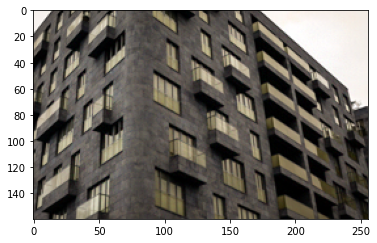

In [13]:
print(predd.max())
predd = np.clip(predd, 0, 1)*255
preddd = np.uint8(predd)
plt.imshow(preddd)

In [14]:
inp = lr_father.to(device)
print(inp.shape)
pred2 = model(inp)
pred3 = pred2.permute(0, 2, 3, 1).squeeze(0)
print(pred3.shape)

torch.Size([1, 3, 160, 256])
torch.Size([640, 1024, 3])


In [15]:
pred4 = pred3.cpu().detach().numpy()
print(pred4.dtype)

float32


In [16]:
print(pred4.max())

1.602803


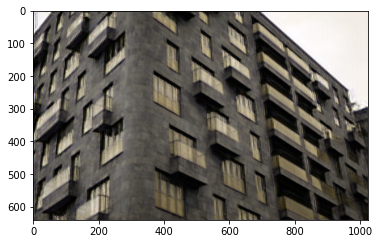

In [17]:
pred5 = np.clip(pred4, 0, 1)*255
pred6 = np.uint8(pred5)
plt.imshow(pred6)

In [19]:
pred6.shape

(640, 1024, 3)